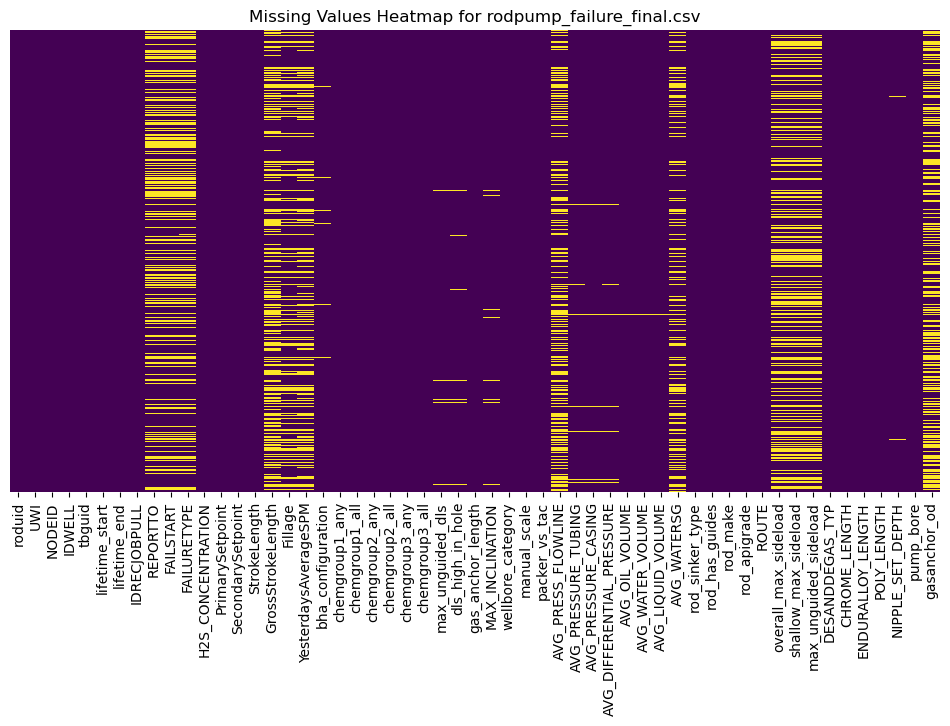

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


 # this code just shows the missing points
# Load the dataset
df = pd.read_csv("../data/rodpump_failure_final.csv")

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cmap="viridis", cbar=False, yticklabels=False)

# Add title
plt.title("Missing Values Heatmap for rodpump_failure_final.csv")

# Show the plot
plt.show()


so lots of failstart are missing but that is just due to the "no fail" not there. we know this based on its end day. along with that i believe we should just drop the missing data we cant use 20% to generalize 80%


due to the missing percent of certain rows we are going PROBABLY going to drop. I am going to check the % missing, if its above 75, i think we have to throw it away.


May drop features:
REPORTTO (this actually just says drop it so don't worry about this one)
GrossStrokeLength
Fillage
yesterdaysAverageSPM
AVG_PRESS_FLOWLINE
AVG_WATERSG
overall_max_sideload
shallow_max_sideload
max_unguided_sideload
gasanchor_od

In [2]:
import pandas as pd

 # we are going to find out the missing % here
 #this includes NAN'S and values that are 0 (we shouldn't have 0's)

 
# Load the original dataset
df = pd.read_csv("../data/rodpump_failure_final.csv")

# Replace literal 0 or 0.0 with NaN so we can treat them together
df_replaced = df.replace([0, 0.0], float('nan'))

# Calculate the fraction of missing values for each column
missing_fraction = df_replaced.isnull().sum() / len(df)

# Print columns with missing values and their missing fraction
print("Fraction of missing data for each column (including 0 or 0.0 as missing):")
print(missing_fraction)


Fraction of missing data for each column (including 0 or 0.0 as missing):
roduid                       0.000000
UWI                          0.000000
NODEID                       0.000000
IDWELL                       0.000000
tbguid                       0.000000
lifetime_start               0.000000
lifetime_end                 0.000000
IDRECJOBPULL                 0.000000
REPORTTO                     0.335516
FAILSTART                    0.335516
FAILURETYPE                  0.337057
H2S_CONCENTRATION            0.945686
PrimarySetpoint              0.003852
SecondarySetpoint            0.066641
StrokeLength                 0.003082
GrossStrokeLength            0.424884
Fillage                      0.253467
YesterdaysAverageSPM         0.309707
bha_configuration            0.017720
chemgroup1_any               0.529661
chemgroup1_all               0.916025
chemgroup2_any               0.766564
chemgroup2_all               0.913713
chemgroup3_any               0.932974
chemgroup3_all

looking to drop:
h2s_concentration (90% missing, can't imputate)
gross_stroke_length (42% missing)
chrome_len (99% missing)
poly_len (98%)
ENDURALLOY_LENGTH (80% missing)
gas_anchorOD (42% missing)
dls - i speak about this right below but essentially its correlation is too high to another variable.

i don't want to get rid of the id things quite yet, but now i will probably start imputating the data that i can. 

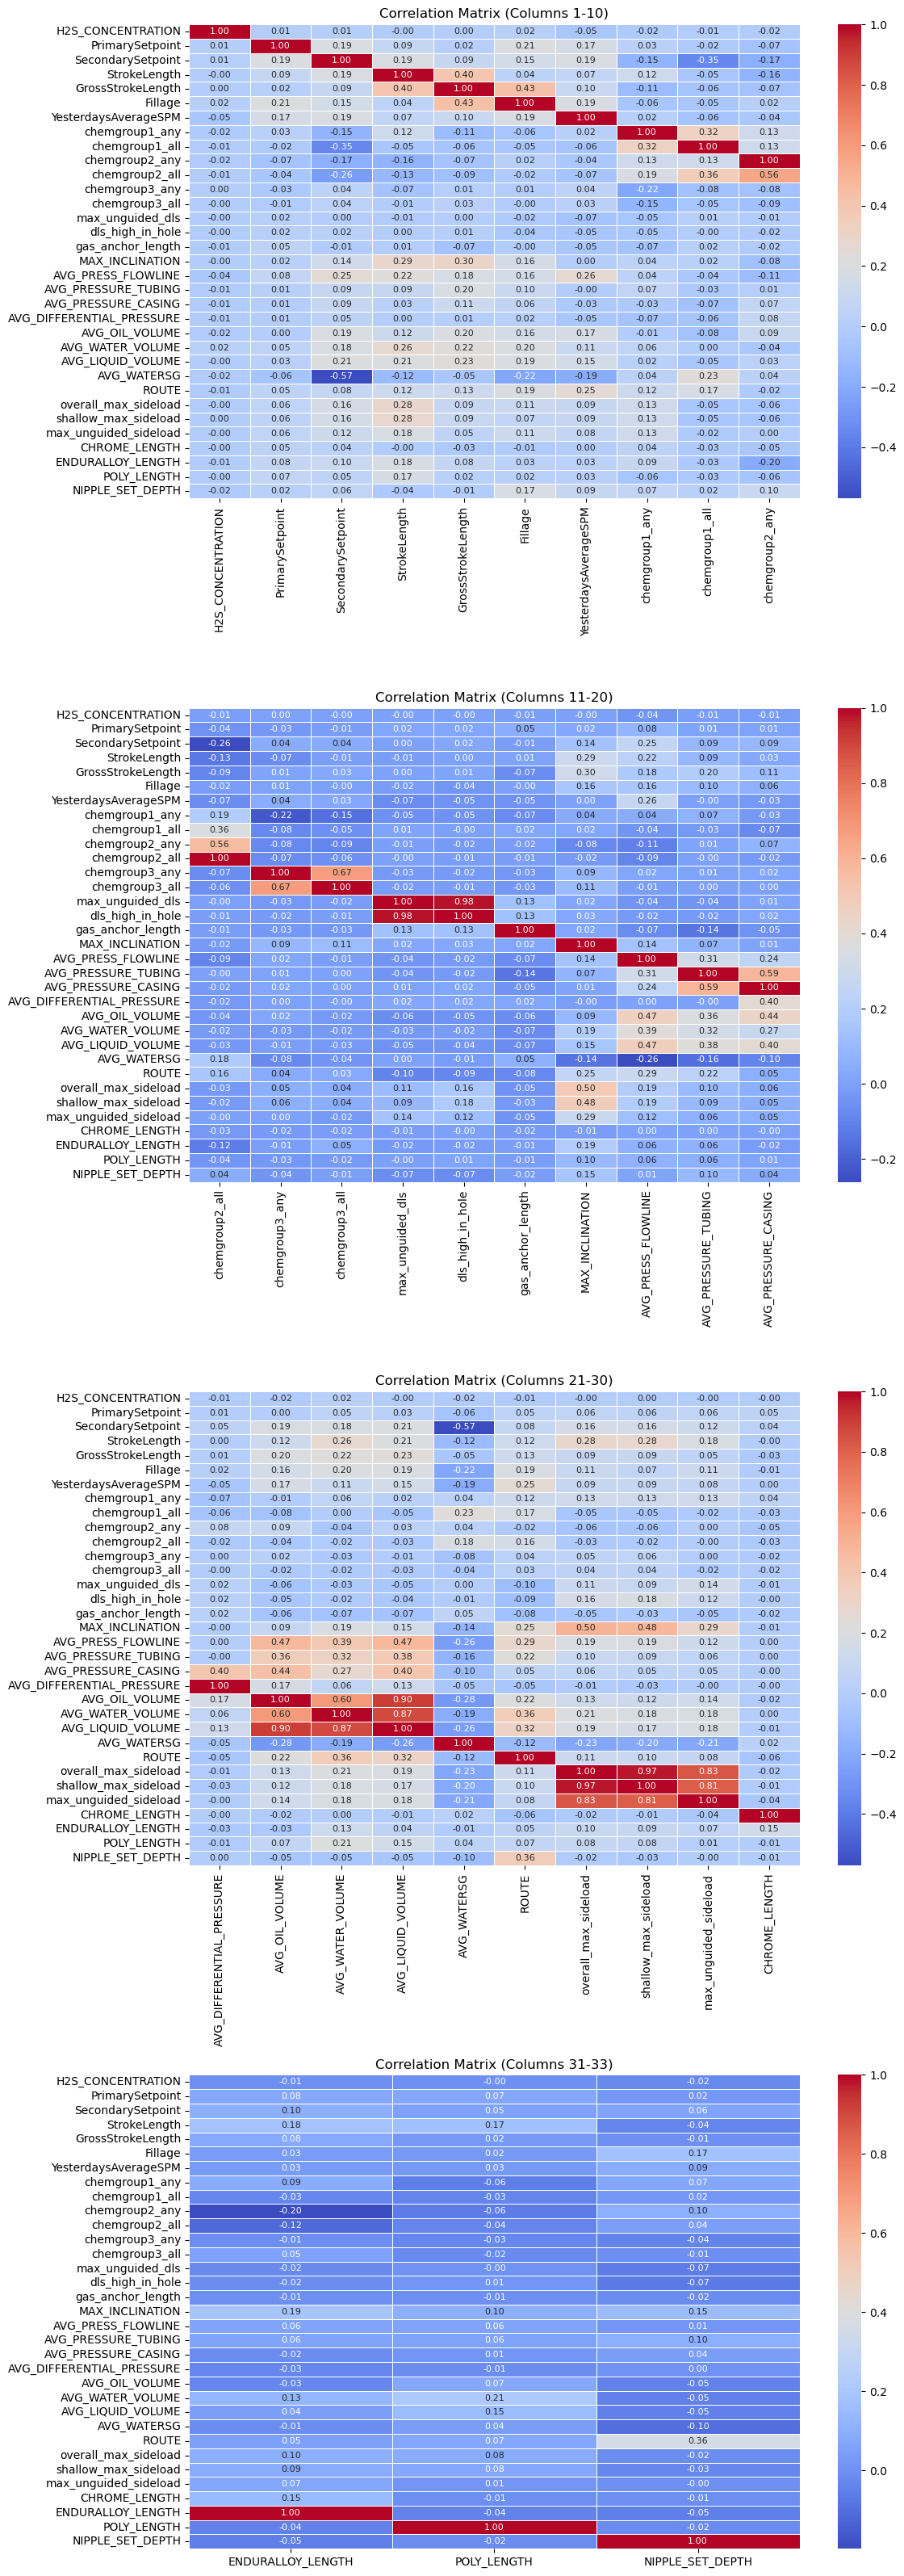

Highest correlations (above 0.7 or below -0.7):
dls_high_in_hole       max_unguided_dls         0.980648
max_unguided_dls       dls_high_in_hole         0.980648
overall_max_sideload   shallow_max_sideload     0.970676
shallow_max_sideload   overall_max_sideload     0.970676
AVG_LIQUID_VOLUME      AVG_OIL_VOLUME           0.901573
AVG_OIL_VOLUME         AVG_LIQUID_VOLUME        0.901573
AVG_WATER_VOLUME       AVG_LIQUID_VOLUME        0.867627
AVG_LIQUID_VOLUME      AVG_WATER_VOLUME         0.867627
overall_max_sideload   max_unguided_sideload    0.833359
max_unguided_sideload  overall_max_sideload     0.833359
shallow_max_sideload   max_unguided_sideload    0.811716
max_unguided_sideload  shallow_max_sideload     0.811716
dtype: float64


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


#this will show some correlations, i just want to see if any of the missing values we have are correlated with one 
#another but i don't think so

# Load your dataset
df = pd.read_csv("../data/rodpump_failure_final.csv")

# Select only numeric columns for correlation calculation
df_numeric = df.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = df_numeric.corr()

# Define how many columns to split per plot (e.g., 10 columns per plot)
columns_per_plot = 10
n_plots = (correlation_matrix.shape[1] // columns_per_plot) + 1

# Create subplots to show multiple graphs
fig, axes = plt.subplots(n_plots, 1, figsize=(12, 8 * n_plots))

# Iterate over the subplots
for i in range(n_plots):
    start_col = i * columns_per_plot
    end_col = start_col + columns_per_plot
    
    # Get a subset of the correlation matrix
    sub_matrix = correlation_matrix.iloc[:, start_col:end_col]
    
    # Plot the heatmap
    sns.heatmap(sub_matrix, annot=True, cmap="coolwarm", fmt=".2f", 
                annot_kws={'size': 8}, linewidths=0.5, ax=axes[i])

    axes[i].set_title(f"Correlation Matrix (Columns {start_col+1}-{min(end_col, correlation_matrix.shape[1])})")

# Adjust layout
plt.tight_layout()
plt.show()

# Print the highest correlations (above 0.7 or below -0.7)
threshold = 0.7
high_correlations = correlation_matrix.unstack().sort_values(ascending=False)

# Filter out self-correlations (where the correlation is 1)
high_correlations = high_correlations[high_correlations < 1]

# Filter for correlations above the threshold or below the negative threshold
high_correlations = high_correlations[(high_correlations > threshold) | (high_correlations < -threshold)]

print("Highest correlations (above 0.7 or below -0.7):")
print(high_correlations)


liquid is all related obviously
so are the sideloads
also dls (basically the bend of the tubing) is really high to one another.
since this is the case, we will drop one and keep the other. Max tends to be better.

In [4]:
#lets go ahead and put it in the noFails in and delete all the columns we don't want anyomre

#we will make another heatmap after that

import pandas as pd

# Load the original dataset
df = pd.read_csv("../data/rodpump_failure_final.csv")

# Fill missing values for 'FAILURE_TYPE' based on 'bha_lifetime_end'
df.loc[df["lifetime_end"] == "2020-04-15 17:37:11.338", "FAILURETYPE"] = df["FAILURETYPE"].fillna("No fail")
df.loc[df["lifetime_end"] != "2020-04-15 17:37:11.338", "FAILURETYPE"] = df["FAILURETYPE"].fillna("Unknown")

# Drop the 'REPORTTO' column as requested
df = df.drop(columns=["REPORTTO"])

# Save the modified dataset to the cleaned directory
df.to_csv("../cleanedData/rodpump_failure_final_cleaned.csv", index=False)

print("Missing values replaced and REPORTTO column dropped. File saved as '../dataCleaned/rodpump_failure_final_cleaned.csv'.")



Missing values replaced and REPORTTO column dropped. File saved as '../dataCleaned/rodpump_failure_final_cleaned.csv'.


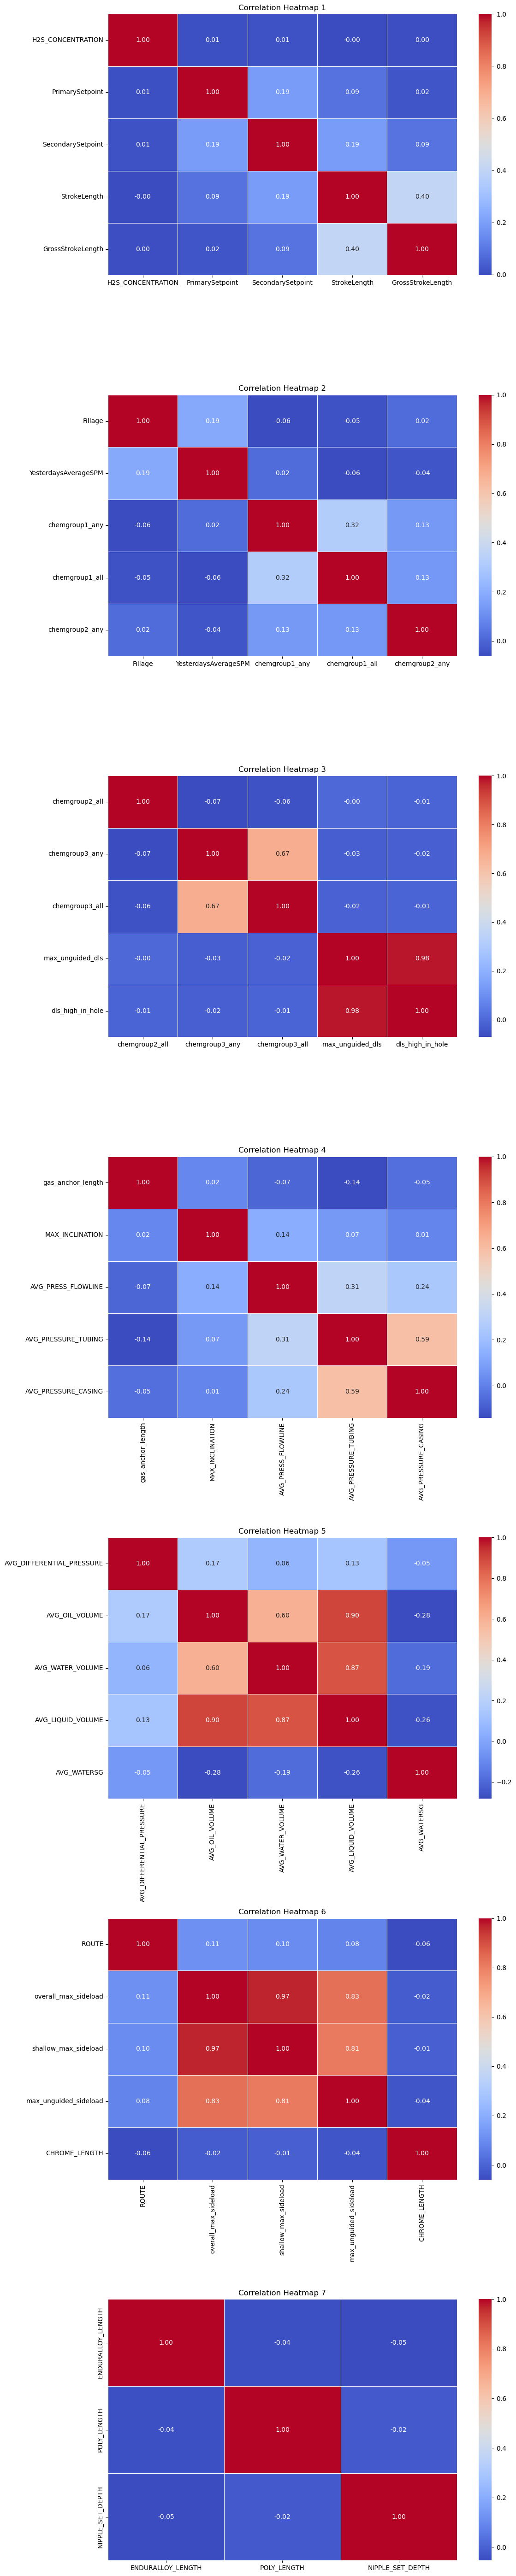

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the cleaned dataset
df_cleaned = pd.read_csv("../cleanedData/rodpump_failure_final_cleaned.csv")

# Select only numeric columns for the correlation matrix
numeric_columns = df_cleaned.select_dtypes(include=['number']).columns
df_numeric = df_cleaned[numeric_columns]

# Calculate the correlation matrix
correlation_matrix = df_numeric.corr()

# Split the correlation matrix into smaller parts
n = len(correlation_matrix.columns)
ncols = 5  # Number of columns per heatmap
nrows = (n // ncols) + (n % ncols > 0)  # Calculate the number of rows needed

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(12, 8 * nrows))

# Plot each smaller heatmap
for i in range(nrows):
    start_col = i * ncols
    end_col = min((i + 1) * ncols, n)
    subset = correlation_matrix.iloc[start_col:end_col, start_col:end_col]
    sns.heatmap(subset, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, ax=axes[i])
    axes[i].set_title(f"Correlation Heatmap {i+1}")

plt.tight_layout()
plt.show()


In [6]:
import pandas as pd

# Load the cleaned dataset
df = pd.read_csv("../cleanedData/rodpump_failure_final_cleaned.csv")

# Drop the specified columns
columns_to_drop = [
    'H2S_CONCENTRATION', 'GrossStrokeLength', 'CHROME_LENGTH', 'POLY_LENGTH',
    'ENDURALLOY_LENGTH', 'gasanchor_od', 'max_unguided_dls', 'dls_high_in_hole', 
    'overall_max_sideload', 'shallow_max_sideload', 'max_unguided_sideload', 'FAILSTART', 'ROUTE','YesterdaysAverageSPM'
    , 'Fillage'
]
df_cleaned = df.drop(columns=columns_to_drop)

# Create the "days_of_life" column
df_cleaned["days_of_life"] = pd.to_datetime(df["lifetime_end"]) - pd.to_datetime(df["lifetime_start"])
df_cleaned["days_of_life"] = df_cleaned["days_of_life"].dt.days  # Convert to integer

# Drop the original date columns
df_cleaned = df_cleaned.drop(columns=["lifetime_start", "lifetime_end"])

# Save the cleaned dataset
df_cleaned.to_csv("../cleanedData/dropped_withZeros.csv", index=False)

print("Dropped specified columns, added 'days_of_life', removed date columns, and saved the cleaned data.")


Dropped specified columns, added 'days_of_life', removed date columns, and saved the cleaned data.


went ahead and delete the identifier columns that added no value, and we made total days of life column and also got rid of the ones used in order to create that.

now we need to begin filling in some values or continue to get rid of values


In [7]:
import pandas as pd

# Load the cleaned dataset
df_cleaned = pd.read_csv("../cleanedData/rodpump_failure_final_cleaned.csv")

# Check for missing or 0 values in the 'YesterdaysAverageSPM' column
df_filtered = df_cleaned[df_cleaned['YesterdaysAverageSPM'].notna() & (df_cleaned['YesterdaysAverageSPM'] != 0)]

# Define the median threshold for 50/50 split
median_threshold = df_filtered['YesterdaysAverageSPM'].median()

# Categorize 'YesterdaysAverageSPM' into Low and High (50/50 split)
df_filtered['spm_category'] = pd.cut(df_filtered['YesterdaysAverageSPM'],
                                     bins=[0, median_threshold, df_filtered['YesterdaysAverageSPM'].max()],
                                     labels=['Low', 'High'])

# Group by 'spm_category' and 'FAILURETYPE' and calculate counts
failure_association = df_filtered.groupby(['spm_category', 'FAILURETYPE']).size().reset_index(name='Count')

# Calculate the total counts for each 'spm_category'
category_totals = df_filtered.groupby('spm_category').size().reset_index(name='Total')

# Merge the counts with the category totals to calculate the fraction for each failure type
result = pd.merge(failure_association, category_totals, on='spm_category')
result['Fraction'] = result['Count'] / result['Total']

# Pivot the table to display the failure types by category
pivoted_result = result.pivot_table(index='FAILURETYPE', columns='spm_category', values='Fraction', aggfunc='sum')

# Display the result
print(pivoted_result)


spm_category          Low      High
FAILURETYPE                        
No fail          0.279915  0.339953
Rods             0.074786  0.108645
Sucker Rod Pump  0.174145  0.120327
Tubing           0.371795  0.358645
Unknown          0.099359  0.072430


C:\Users\angel\AppData\Local\Temp\ipykernel_27128\2050038148.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['spm_category'] = pd.cut(df_filtered['YesterdaysAverageSPM'],
C:\Users\angel\AppData\Local\Temp\ipykernel_27128\2050038148.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  failure_association = df_filtered.groupby(['spm_category', 'FAILURETYPE']).size().reset_index(name='Count')
C:\Users\angel\AppData\Local\Temp\ipykernel_27128\2050038148.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True

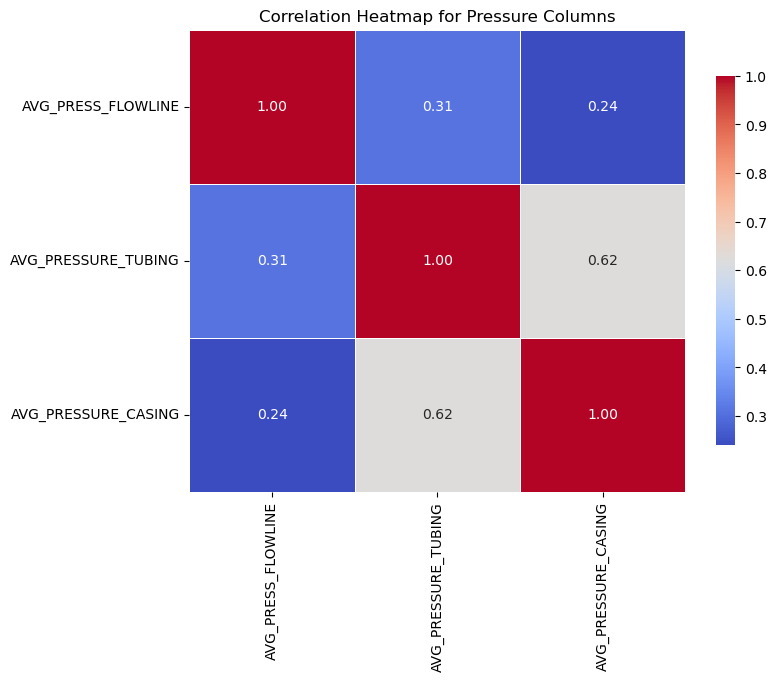

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the cleaned dataset
df_cleaned = pd.read_csv("../cleanedData/rodpump_failure_final_cleaned.csv")

# Select the relevant columns
pressure_cols = ['AVG_PRESS_FLOWLINE', 'AVG_PRESSURE_TUBING', 'AVG_PRESSURE_CASING']

# Filter out rows where any of these columns have NaN or 0
df_filtered = df_cleaned[
    (df_cleaned[pressure_cols[0]].notna()) & (df_cleaned[pressure_cols[1]].notna()) & (df_cleaned[pressure_cols[2]].notna()) &
    (df_cleaned[pressure_cols[0]] != 0) & (df_cleaned[pressure_cols[1]] != 0) & (df_cleaned[pressure_cols[2]] != 0)
]

# Calculate the correlation matrix
correlation_matrix = df_filtered[pressure_cols].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title("Correlation Heatmap for Pressure Columns")
plt.show()


In [10]:
import pandas as pd

# Load the cleaned dataset
df_cleaned = pd.read_csv("../cleanedData/rodpump_failure_final_cleaned.csv")

# Filter out rows where AVG_PRESS_FLOWLINE is NaN or 0
df_filtered = df_cleaned[df_cleaned['AVG_PRESS_FLOWLINE'].notna() & (df_cleaned['AVG_PRESS_FLOWLINE'] != 0)]

# Calculate the quantiles (33rd and 66th percentiles)
low_threshold = df_filtered['AVG_PRESS_FLOWLINE'].quantile(0.33)
high_threshold = df_filtered['AVG_PRESS_FLOWLINE'].quantile(0.66)

# Assign categories based on the quantiles
df_filtered['pressure_category'] = pd.cut(df_filtered['AVG_PRESS_FLOWLINE'], bins=[0, low_threshold, high_threshold, df_filtered['AVG_PRESS_FLOWLINE'].max()],
                                          labels=['Low', 'Medium', 'High'], include_lowest=True)

# Now, we can group by 'pressure_category' and see which failure types are associated with each category
failure_association = df_filtered.groupby(['pressure_category', 'FAILURETYPE']).size().reset_index(name='Count')

# Calculate the total for each pressure category
category_totals = df_filtered.groupby('pressure_category').size().reset_index(name='Total')

# Merge the totals with the failure_association DataFrame
result = pd.merge(failure_association, category_totals, on='pressure_category', how='left')

# Add a new column that shows the fraction (count / total)
result['Fraction'] = result['Count'] / result['Total']

# Pivot the result to make it easier to compare
pivoted_result = result.pivot_table(index='FAILURETYPE', columns='pressure_category', values='Fraction', aggfunc='sum')

# Sort the failure types to make it easier to compare
pivoted_result = pivoted_result.sort_index(axis=0, ascending=True)

# Display the result
print(pivoted_result)


pressure_category       Low    Medium      High
FAILURETYPE                                    
No fail            0.312044  0.319343  0.398230
Rods               0.067518  0.098540  0.104425
Sucker Rod Pump    0.209854  0.118613  0.090265
Tubing             0.322993  0.394161  0.309735
Unknown            0.087591  0.069343  0.097345


C:\Users\angel\AppData\Local\Temp\ipykernel_27128\743051226.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['pressure_category'] = pd.cut(df_filtered['AVG_PRESS_FLOWLINE'], bins=[0, low_threshold, high_threshold, df_filtered['AVG_PRESS_FLOWLINE'].max()],
C:\Users\angel\AppData\Local\Temp\ipykernel_27128\743051226.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  failure_association = df_filtered.groupby(['pressure_category', 'FAILURETYPE']).size().reset_index(name='Count')
C:\Users\angel\AppData\Local\Temp\ipykernel_27128\743051226.py:21:

In [11]:
import pandas as pd

# Load the cleaned dataset
df_cleaned = pd.read_csv("../cleanedData/rodpump_failure_final_cleaned.csv")

# List all the chemgroup columns
chemgroup_columns = [
    'chemgroup1_any', 'chemgroup2_any', 'chemgroup3_any'
]

# Filter rows where any of the chemgroup columns are 1 (indicating treatment)
df_treated = df_cleaned[df_cleaned[chemgroup_columns].eq(1).any(axis=1)]

# Get the distribution of FAILURETYPE for these rows
treated_failure_types = df_treated['FAILURETYPE'].value_counts(normalize=True)

# Print the failure type distribution for wells that have had any treatment
print("Failure types associated with wells that have had any treatment:")
print(treated_failure_types)


Failure types associated with wells that have had any treatment:
FAILURETYPE
Tubing             0.429102
No fail            0.190712
Sucker Rod Pump    0.175851
Rods               0.105263
Unknown            0.099071
Name: proportion, dtype: float64


if it has been treaated, there is a clear dispraportion so we will just make a new column

In [12]:
import pandas as pd

# Load the cleaned dataset
df_cleaned = pd.read_csv("../cleanedData/dropped_withZeros.csv")

# Create a new column 'chemically_treated' by checking if any of the chemgroup columns have a value of 1
df_cleaned['chemically_treated'] = df_cleaned[['chemgroup1_any', 'chemgroup2_any', 'chemgroup3_any']].eq(1).any(axis=1).astype(int)

# Drop the original 'chemgroup' columns and their '_all' counterparts
columns_to_drop = ['chemgroup1_any', 'chemgroup2_any', 'chemgroup3_any', 'chemgroup1_all', 'chemgroup2_all', 'chemgroup3_all']
df_cleaned.drop(columns=columns_to_drop, inplace=True)

# Save the cleaned dataset
df_cleaned.to_csv("../cleanedData/chemically_treated_data.csv", index=False)

print("Replaced 'chemgroup' columns with 'chemically_treated' and saved the cleaned data.")


Replaced 'chemgroup' columns with 'chemically_treated' and saved the cleaned data.


In [13]:
import pandas as pd

# Load the cleaned dataset
df_cleaned = pd.read_csv("../cleanedData/rodpump_failure_final_cleaned.csv")

# Group the data by 'bha_configuration' and 'FAILURETYPE' and count the occurrences
failure_by_bha_config = df_cleaned.groupby(['bha_configuration', 'FAILURETYPE']).size().reset_index(name='Count')

# Optionally, normalize it to get fractions for each 'bha_configuration'
failure_by_bha_config['Fraction'] = failure_by_bha_config.groupby('bha_configuration')['Count'].transform(lambda x: x / x.sum())

# Display the results
print(failure_by_bha_config)

# If you want to pivot the table for better readability (optional)
pivoted_result = failure_by_bha_config.pivot_table(index='FAILURETYPE', columns='bha_configuration', values='Fraction', aggfunc='sum')

print("\nPivoted Table for Better Readability:")
print(pivoted_result)


    bha_configuration      FAILURETYPE  Count  Fraction
0        NOSEP_PACKER          No fail     10  0.250000
1        NOSEP_PACKER             Rods      2  0.050000
2        NOSEP_PACKER  Sucker Rod Pump      9  0.225000
3        NOSEP_PACKER           Tubing     11  0.275000
4        NOSEP_PACKER          Unknown      8  0.200000
5       PACKER_DONNAN          No fail    114  0.182109
6       PACKER_DONNAN             Rods     51  0.081470
7       PACKER_DONNAN  Sucker Rod Pump    157  0.250799
8       PACKER_DONNAN           Tubing    210  0.335463
9       PACKER_DONNAN          Unknown     94  0.150160
10  PACKER_TAC_DONNAN          No fail     17  0.088083
11  PACKER_TAC_DONNAN             Rods      7  0.036269
12  PACKER_TAC_DONNAN  Sucker Rod Pump    125  0.647668
13  PACKER_TAC_DONNAN           Tubing     29  0.150259
14  PACKER_TAC_DONNAN          Unknown     15  0.077720
15      TAC_ABOVE_NIP          No fail    119  0.130197
16      TAC_ABOVE_NIP             Rods     84  0

In [14]:
import pandas as pd

# Load the chemically treated data
df = pd.read_csv("../cleanedData/chemically_treated_data.csv")

# Drop rows where bha_configuration is NaN or missing
df = df.dropna(subset=['bha_configuration'])

# Define the BHA configurations
bha_configs = [
    'NOSEP_PACKER', 'PACKER_DONNAN', 'PACKER_TAC_DONNAN', 'TAC_ABOVE_NIP', 'TAC_BELOW_NIP'
]

# Create binary columns for each BHA configuration
for config in bha_configs:
    df[config] = df['bha_configuration'].apply(lambda x: 1 if isinstance(x, str) and config in str(x) else 0)

# Save the new dataframe with binary columns
df.to_csv("../cleanedData/bha_config.csv", index=False)

print("Dropped rows without bha_configuration and created binary columns for BHA configurations.")


Dropped rows without bha_configuration and created binary columns for BHA configurations.


In [15]:
# Importing the Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

# Step 1: Drop rows where 'SecondarySetpoint' is 0
df_filtered = df[df['SecondarySetpoint'] != 0]

# Step 2: Prepare the training data where both 'AVG_WATERSG' and 'SecondarySetpoint' are available
train_data = df_filtered.dropna(subset=['AVG_WATERSG', 'SecondarySetpoint'])

# Features (predictor) and Target (what we are predicting)
X_train = train_data[['SecondarySetpoint']]  # Predictor (SecondarySetpoint)
y_train = train_data['AVG_WATERSG']  # Target (AVG_WATERSG)

# Step 3: Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 4: Predict missing 'AVG_WATERSG' values
missing_data = df_filtered[df_filtered['AVG_WATERSG'].isna()]
predicted_values = rf_model.predict(missing_data[['SecondarySetpoint']])

# Step 5: Fill in the missing AVG_WATERSG values with the predicted ones
df_filtered.loc[df_filtered['AVG_WATERSG'].isna(), 'AVG_WATERSG'] = predicted_values

# Step 6: Save the updated DataFrame to 'avg_watersg.csv'
df_filtered.to_csv("../cleanedData/avg_watersg.csv", index=False)


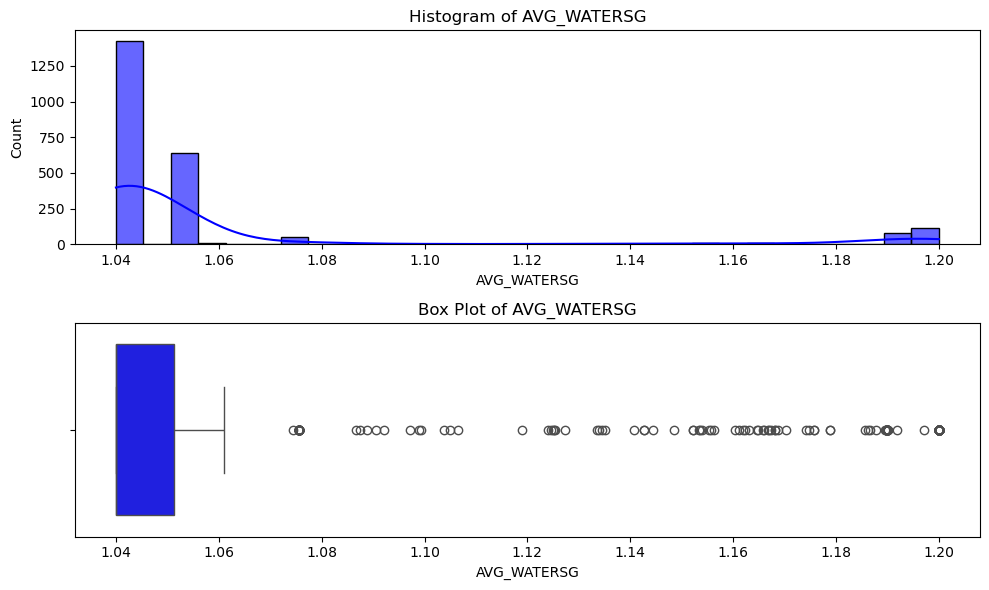

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# Histogram
plt.subplot(2, 1, 1)
sns.histplot(df_filtered['AVG_WATERSG'], bins=30, kde=True, color='blue', alpha=0.6)
plt.xlabel("AVG_WATERSG")
plt.ylabel("Count")
plt.title("Histogram of AVG_WATERSG")

# Box plot
plt.subplot(2, 1, 2)
sns.boxplot(x=df_filtered['AVG_WATERSG'], color='blue')
plt.xlabel("AVG_WATERSG")
plt.title("Box Plot of AVG_WATERSG")

plt.tight_layout()
plt.show()


In [17]:
import pandas as pd

# Filter out NaNs and zeros
df_filtered = df[(df['AVG_WATERSG'].notna()) & (df['AVG_WATERSG'] > 0)].copy()

# Categorize into Low (≤1.10) and High (>1.10)
df_filtered['watersg_category'] = df_filtered['AVG_WATERSG'].apply(lambda x: 'Low' if x <= 1.10 else 'High')

# Count failure types in each category
failure_counts = df_filtered.groupby(['watersg_category', 'FAILURETYPE']).size().reset_index(name='Count')

# Get totals per category
category_totals = df_filtered['watersg_category'].value_counts().reset_index()
category_totals.columns = ['watersg_category', 'Total']

# Merge and compute fractions
result = failure_counts.merge(category_totals, on='watersg_category')
result['Fraction'] = result['Count'].astype(str) + " / " + result['Total'].astype(str)

# Pivot for easier reading
pivoted_result = result.pivot(index='FAILURETYPE', columns='watersg_category', values='Fraction')

# Display result
print(pivoted_result)


watersg_category       High         Low
FAILURETYPE                            
No fail           182 / 392  341 / 1443
Rods               27 / 392  129 / 1443
Sucker Rod Pump    66 / 392  227 / 1443
Tubing             74 / 392  620 / 1443
Unknown            43 / 392  126 / 1443


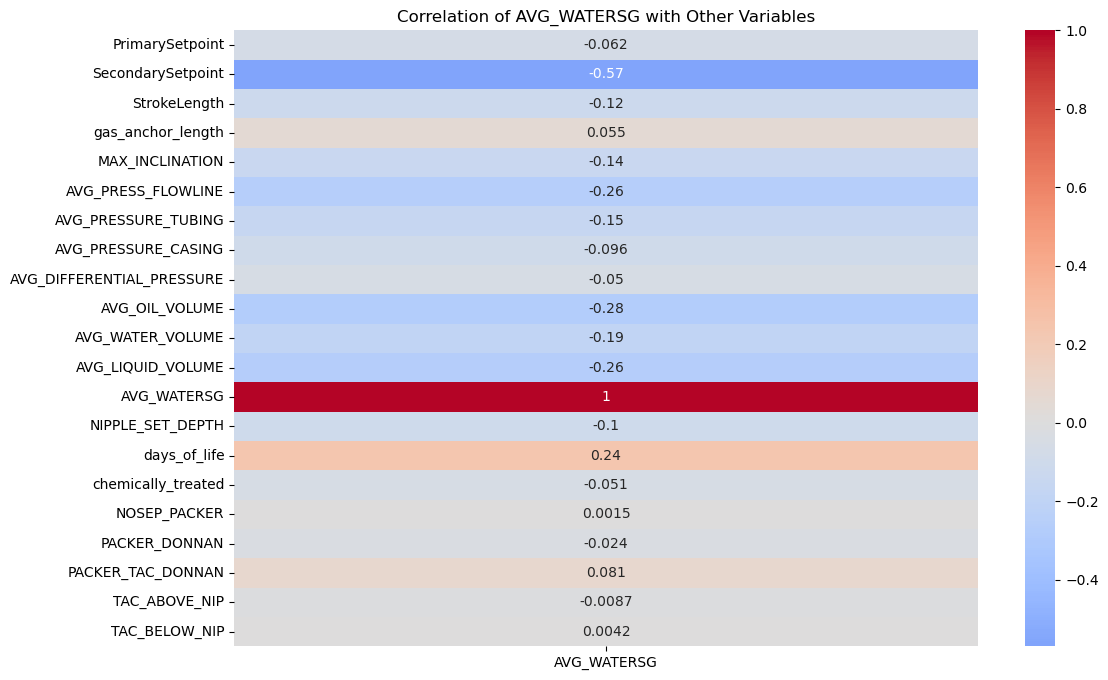

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out rows with NaN or 0 in AVG_WATERSG
df_filtered = df[df['AVG_WATERSG'].notna() & (df['AVG_WATERSG'] != 0)]

# Select only numeric columns for correlation
numeric_columns = df_filtered.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()

# Generate a heatmap of correlations for AVG_WATERSG with all other variables
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix[['AVG_WATERSG']], annot=True, cmap='coolwarm', center=0)
plt.title('Correlation of AVG_WATERSG with Other Variables')
plt.show()


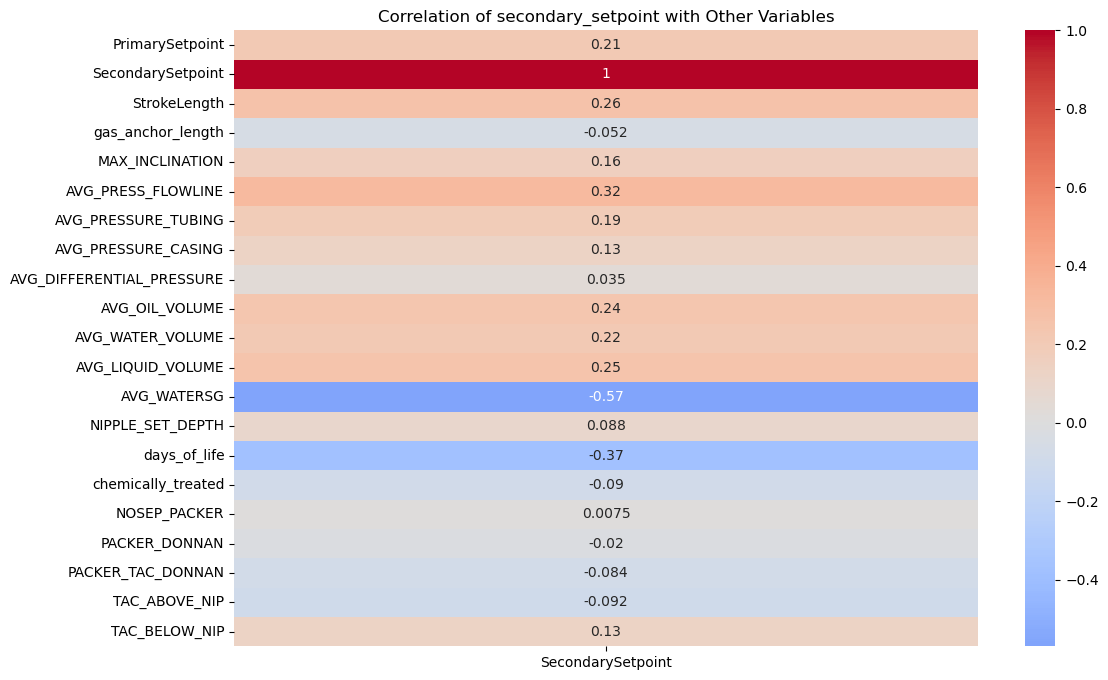

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out rows with NaN or 0 in AVG_WATERSG
df_filtered = df[df['AVG_WATERSG'].notna() & (df['AVG_WATERSG'] != 0)]

# Select only numeric columns for correlation
numeric_columns = df_filtered.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()

# Generate a heatmap of correlations for secondary_setpoint with other variables
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix[['SecondarySetpoint']], annot=True, cmap='coolwarm', center=0)
plt.title('Correlation of secondary_setpoint with Other Variables')
plt.show()


In [20]:
# Filter the data where 'SecondarySetpoint' is 0
secondary_zero_data = df[df['SecondarySetpoint'] == 0]

# Count the occurrences of each 'FAILURETYPE' in this subset
failure_type_counts = secondary_zero_data['FAILURETYPE'].value_counts()

# Display the result
print(failure_type_counts)


FAILURETYPE
No fail            66
Sucker Rod Pump    37
Tubing             36
Unknown            25
Rods                8
Name: count, dtype: int64


In [21]:
# Step 1: Drop rows where 'SecondarySetpoint' is 0
df_filtered = df[df['SecondarySetpoint'] != 0]

# Step 2: Apply the regression model to predict 'AVG_WATERSG' where it's missing
# Prepare the training data where both 'AVG_WATERSG' and 'SecondarySetpoint' are available
train_data = df_filtered.dropna(subset=['AVG_WATERSG', 'SecondarySetpoint'])

# Prepare the feature (SecondarySetpoint) and target (AVG_WATERSG)
X_train = train_data[['SecondarySetpoint']]  # Predictor (SecondarySetpoint)
y_train = train_data['AVG_WATERSG']  # Target (AVG_WATERSG)

# Train a linear regression model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

# Step 3: Predict missing 'AVG_WATERSG' values
missing_data = df_filtered[df_filtered['AVG_WATERSG'].isna()]
predicted_values = model.predict(missing_data[['SecondarySetpoint']])

# Fill in the missing AVG_WATERSG values with the predicted ones
df_filtered.loc[df_filtered['AVG_WATERSG'].isna(), 'AVG_WATERSG'] = predicted_values

# Step 4: Save the updated DataFrame to 'avg_watersg.csv'
df_filtered.to_csv("../cleanedData/avg_watersg.csv", index=False)


In [22]:
# Load the avg_watersg.csv file first
df_filtered = pd.read_csv("../cleanedData/avg_watersg.csv")

# Drop the AVG_PRESS_FLOWLINE column
df_filtered = df_filtered.drop(columns=['AVG_PRESS_FLOWLINE'])

# Save the cleaned dataframe back into the avg_watersg.csv file
df_filtered.to_csv("../cleanedData/droppedavg_watresg.csv", index=False)


In [23]:
# Load the cleaned data from the avg_watersg.csv file
df = pd.read_csv("../cleanedData/avg_watersg.csv")

# Calculate the percentage of missing data for each column
missing_data_percentage = df.isna().mean() * 100

# Calculate the percentage of zeros in each column (excluding NaNs)
zeros_percentage = (df == 0).mean() * 100

# Combine the two
missing_and_zeros = pd.DataFrame({
    'Missing (%)': missing_data_percentage,
    'Zeros (%)': zeros_percentage
})

# Print the top 20 columns with the highest missing or zero data percentage
print(missing_and_zeros.sort_values(by='Missing (%)', ascending=False).head(20))


                           Missing (%)  Zeros (%)
AVG_PRESS_FLOWLINE           36.375105   0.000000
AVG_PRESSURE_TUBING           2.228764   4.583684
AVG_DIFFERENTIAL_PRESSURE     2.060555   4.625736
AVG_PRESSURE_CASING           1.976451   2.607233
MAX_INCLINATION               1.766190   0.378469
AVG_WATER_VOLUME              0.588730   1.135408
AVG_OIL_VOLUME                0.588730   1.009251
AVG_LIQUID_VOLUME             0.588730   0.841043
NIPPLE_SET_DEPTH              0.252313   0.000000
wellbore_category             0.168209   0.000000
rod_apigrade                  0.168209   0.000000
pump_bore                     0.000000   0.000000
DESANDDEGAS_TYP               0.000000   0.000000
AVG_WATERSG                   0.000000   0.000000
days_of_life                  0.000000   0.000000
rod_make                      0.000000   0.000000
rod_has_guides                0.000000  61.900757
chemically_treated            0.000000  38.898234
NOSEP_PACKER                  0.000000  98.444071


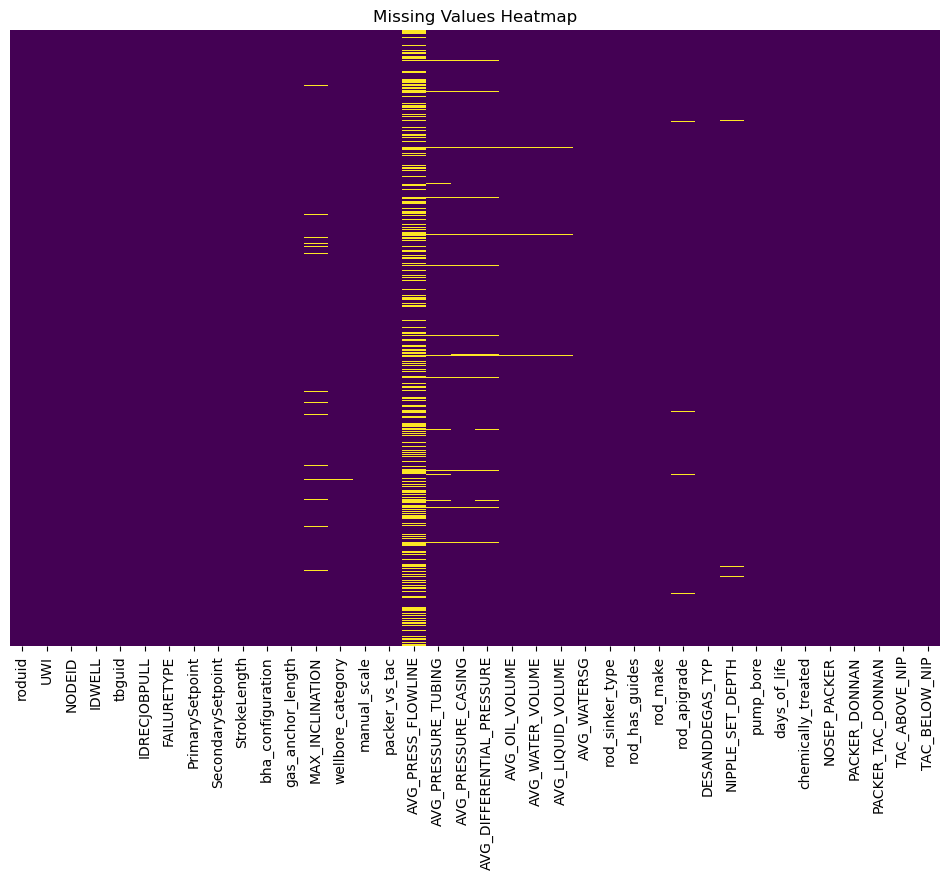

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load the cleaned data from the avg_watersg.csv file
df = pd.read_csv("../cleanedData/avg_watersg.csv")

# Create a heatmap showing missing values
plt.figure(figsize=(12, 8))
sns.heatmap(df.isna(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Values Heatmap')
plt.show()


In [25]:
# Load the cleaned data from the droppedavg_watersg.csv file
df = pd.read_csv("../cleanedData/droppedavg_watersg.csv")

# Print the number of rows in the dataset
print(f"Number of rows in the dataset: {len(df)}")

# Print the distribution of failure types
failure_counts = df['FAILURETYPE'].value_counts()
print("Failure type distribution:")
print(failure_counts)


Number of rows in the dataset: 1513
Failure type distribution:
FAILURETYPE
Tubing             542
No fail            498
Sucker Rod Pump    203
Rods               144
Unknown            126
Name: count, dtype: int64


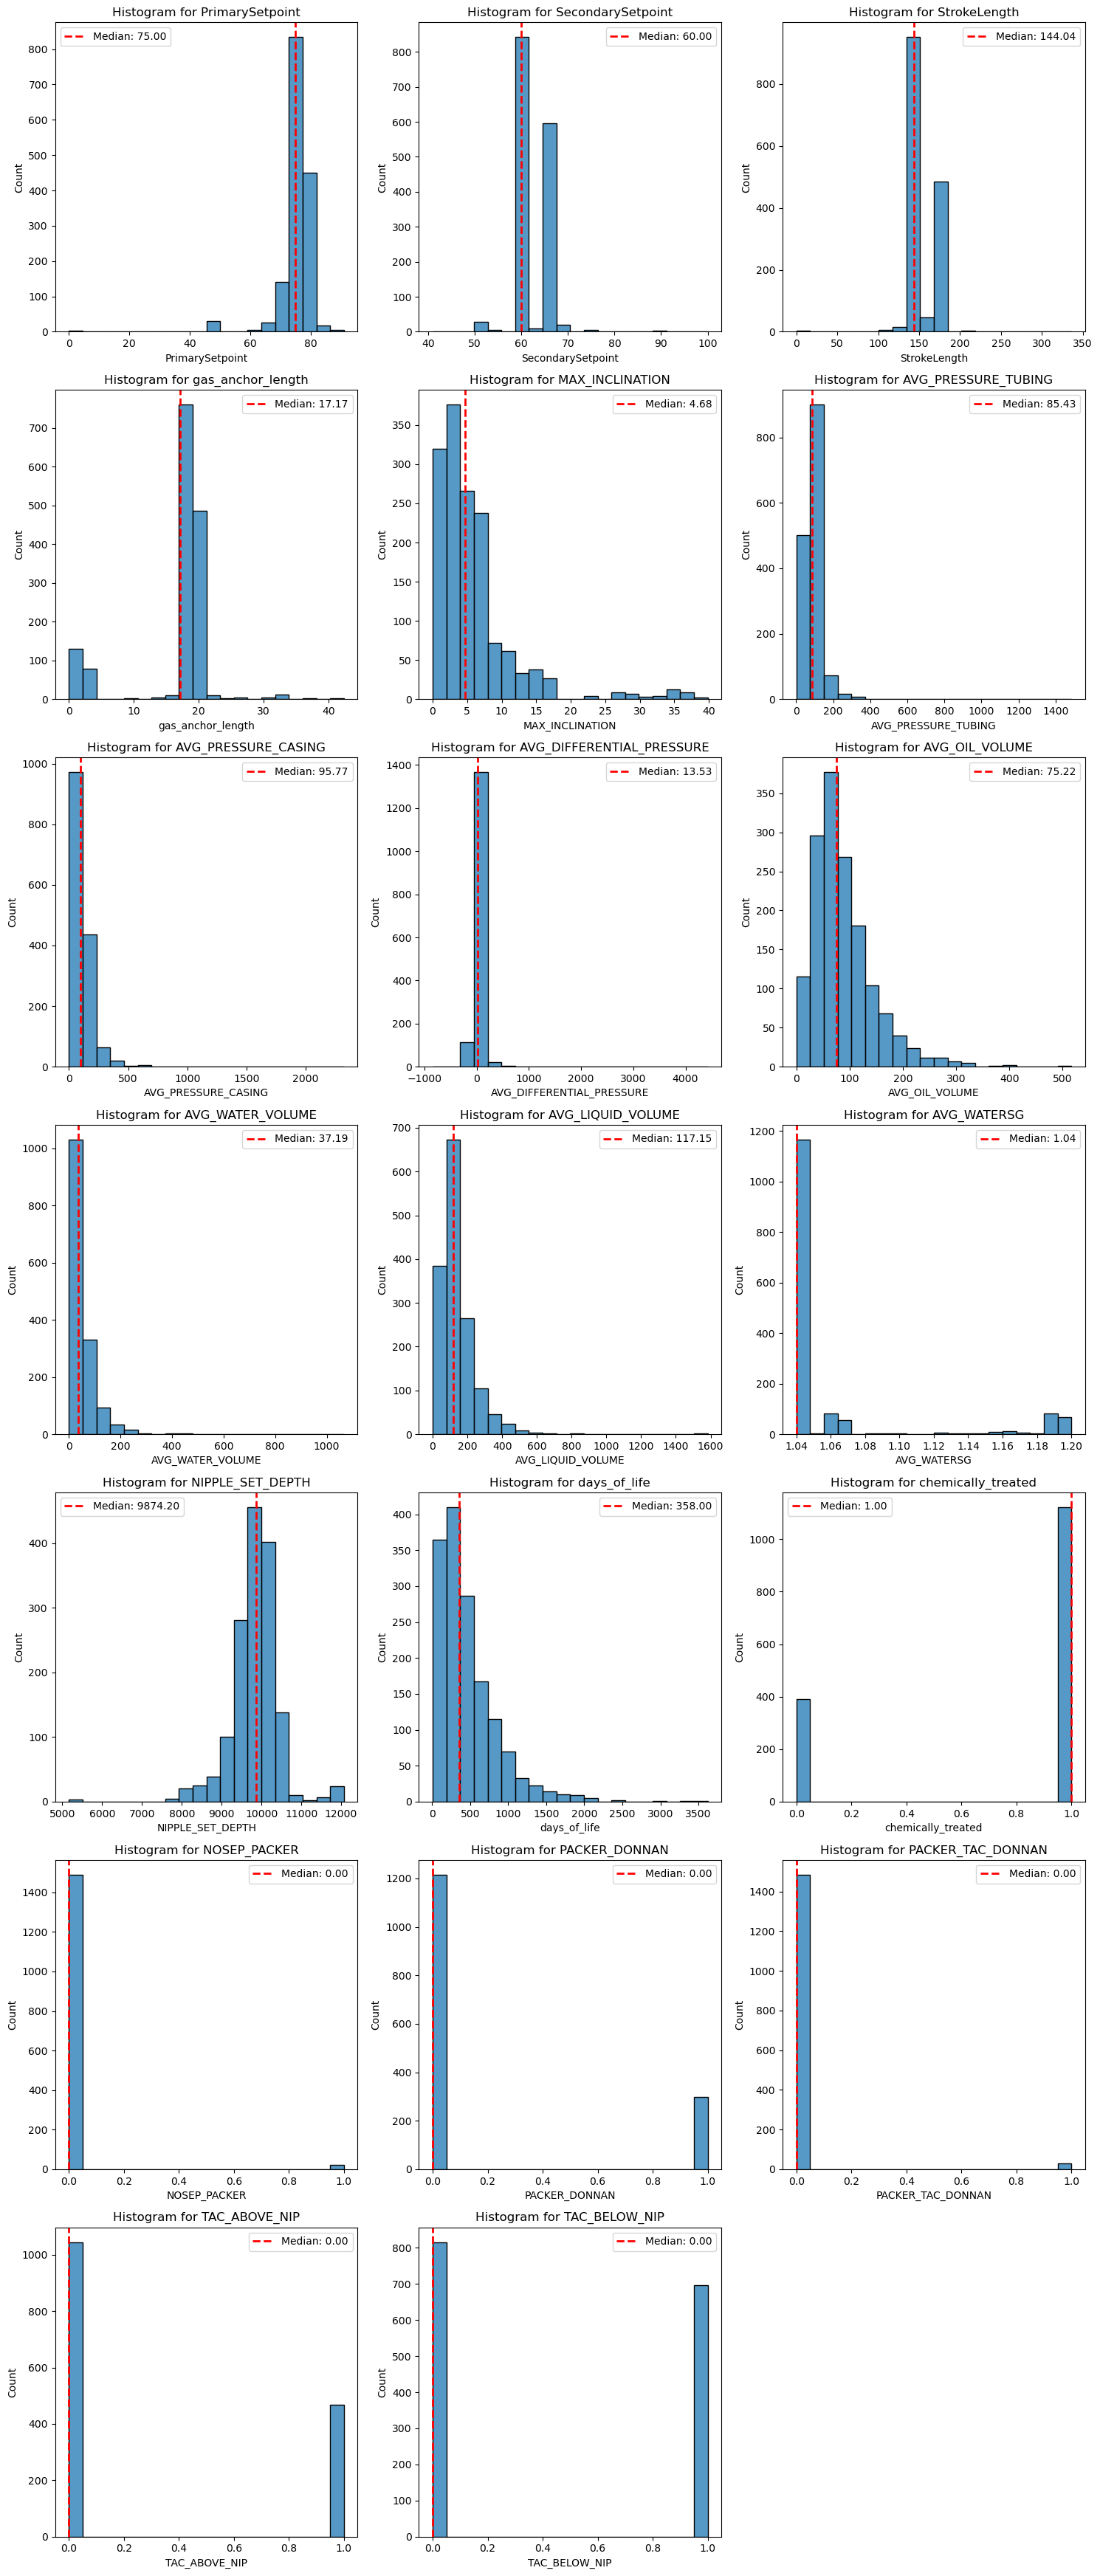

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the cleaned data from the droppedavg_watersg.csv file
df = pd.read_csv("../cleanedData/droppedavg_watersg.csv")

# Identify columns that are not strings or boolean (1/0)
numeric_columns = df.select_dtypes(exclude=['object', 'bool']).columns

# Determine grid size for subplots based on the number of columns
num_cols = 3  # Number of columns in the subplot grid
num_rows = int(np.ceil(len(numeric_columns) / num_cols))  # Number of rows

# Create a histogram for each numeric column with median line
plt.figure(figsize=(15, 5 * num_rows))  # Adjust figure size based on the number of rows
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(df[column], kde=False, bins=20)  # Create histogram
    median_value = df[column].median()  # Calculate median
    plt.axvline(median_value, color='red', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')
    plt.title(f"Histogram for {column}")
    plt.legend()
    plt.tight_layout()

plt.show()


In [27]:
import pandas as pd

# Load the dataframe
df = pd.read_csv('../cleanedData/droppedavg_watersg.csv')

# Drop rows where 'max_inclination' is NaN
df_filtered = df[df['MAX_INCLINATION'].notna()]

# Save the filtered dataframe to a new file
df_filtered.to_csv('../cleanedData/max_inclination.csv', index=False)


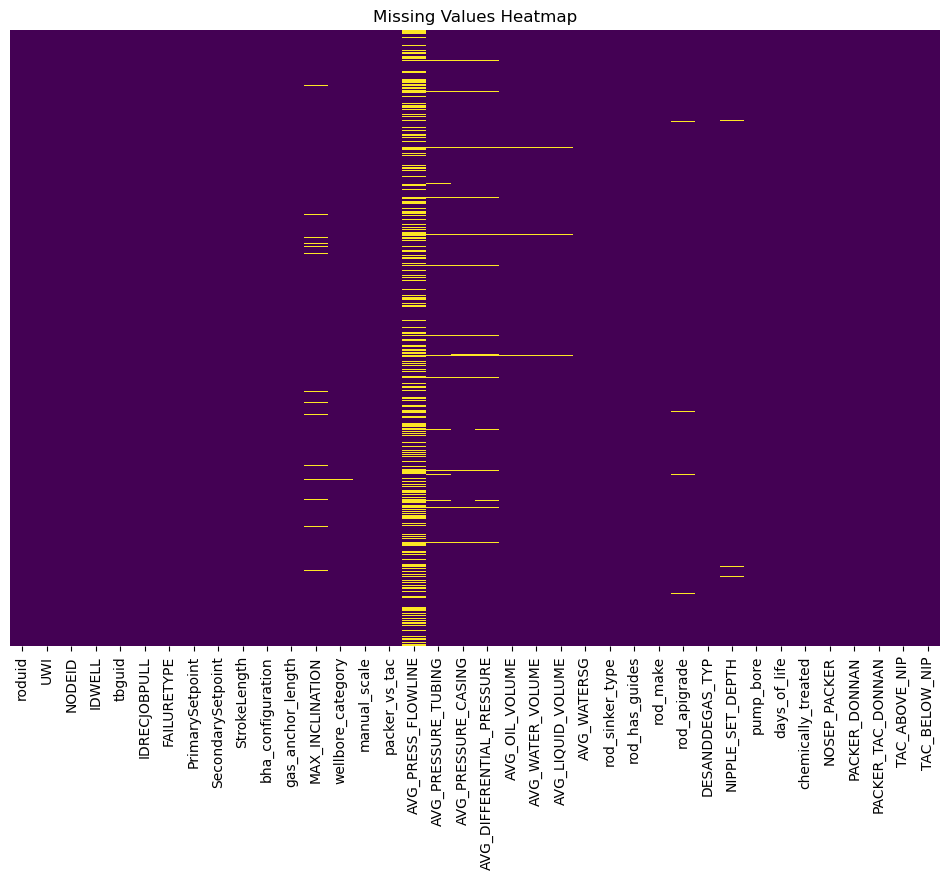

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load the cleaned data from the avg_watersg.csv file
df = pd.read_csv("../cleanedData/avg_watersg.csv")

# Create a heatmap showing missing values
plt.figure(figsize=(12, 8))
sns.heatmap(df.isna(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Values Heatmap')
plt.show()


In [29]:
import pandas as pd

# Load the dataframe
df = pd.read_csv('../cleanedData/max_inclination.csv')

# Drop rows with any NaN values
df_cleaned = df.dropna()

# Save the cleaned dataframe to a new file
df_cleaned.to_csv('../cleanedData/cleanedFinal.csv', index=False)


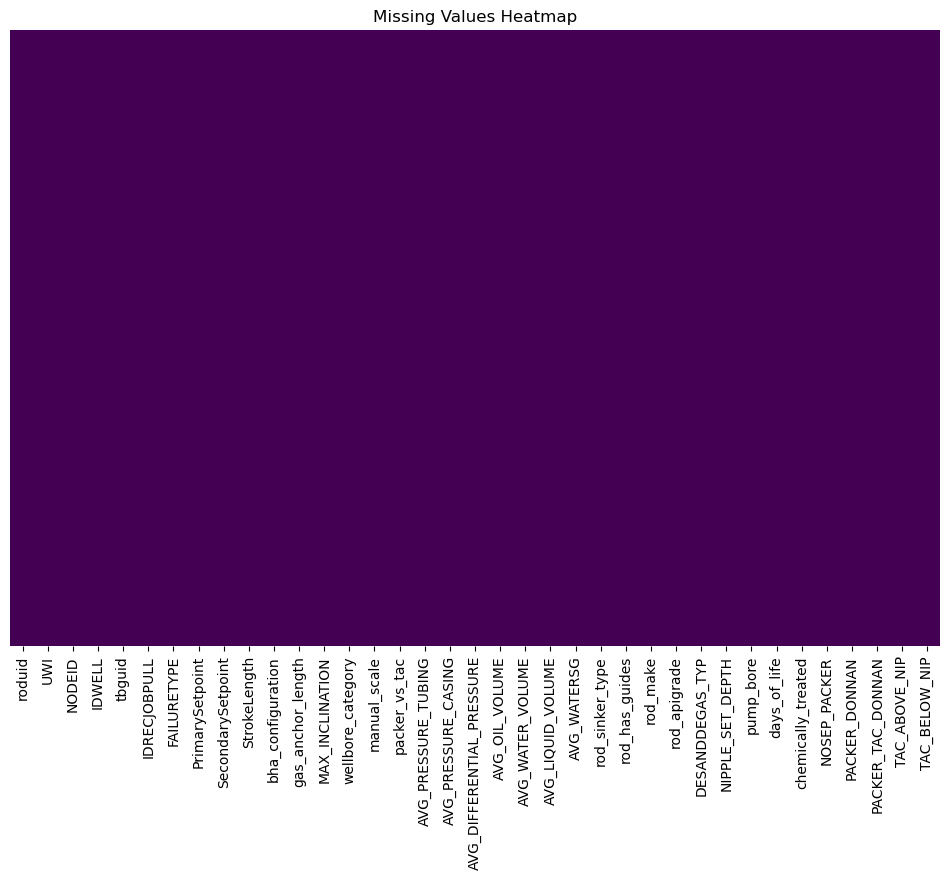

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load the cleaned data from the avg_watersg.csv file
df = pd.read_csv("../cleanedData/cleanedFinal.csv")

# Create a heatmap showing missing values
plt.figure(figsize=(12, 8))
sns.heatmap(df.isna(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Values Heatmap')
plt.show()


In [31]:
import pandas as pd

# Load the cleanedFinal file
df = pd.read_csv('../cleanedData/cleanedFinal.csv')

# Drop the specified columns
columns_to_drop = ['roduid', 'UWI', 'NODEID', 'IDWELL', 'tbguid', 'IDRECJOBPULL']
df_cleaned = df.drop(columns=columns_to_drop)

# Save the cleaned dataframe to a new file called IdentifiersFinal
df_cleaned.to_csv('../cleanedData/IdentifiersFinal.csv', index=False)


In [32]:
import pandas as pd

# Load the IdentifiersFinal file
df = pd.read_csv('../cleanedData/IdentifiersFinal.csv')

# Drop rows where FAILURETYPE is "Unknown"
df_cleaned = df[df['FAILURETYPE'] != 'Unknown']

# Save the cleaned dataframe to the same file
df_cleaned.to_csv('../cleanedData/CLASSIFICATIONFINAL.csv', index=False)


Unique failure types remaining: ['Tubing' 'Rods' 'Sucker Rod Pump']
Cleaned file saved as: ../cleanedData/NOFailClass.csv
Original shape: (1349, 31), New shape: (866, 30)


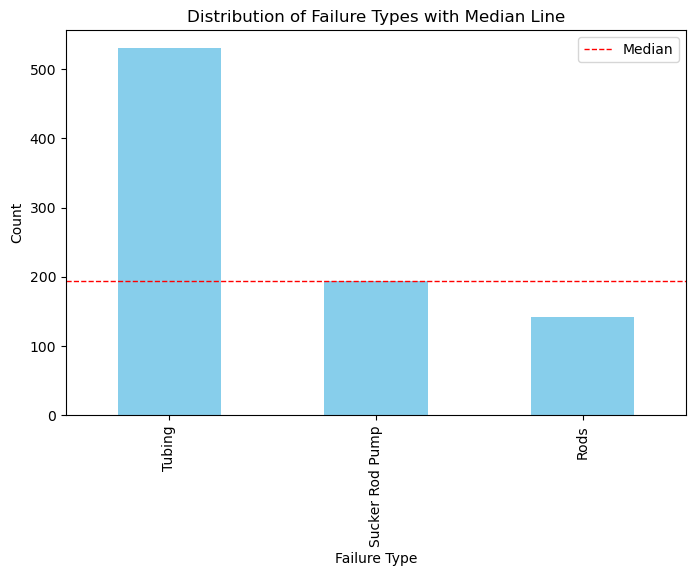

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
file_path = '../cleanedData/CLASSIFICATIONFINAL.csv'
df = pd.read_csv(file_path)

# Drop rows where 'failure_type' is 'Unknown' or 'No fail'
df_filtered = df[~df['FAILURETYPE'].isin(['Unknown', 'No fail'])].copy()

# Drop the 'bha_configuration' column
df_filtered.drop(columns=['bha_configuration'], inplace=True, errors='ignore')

# Save the cleaned file
output_path = '../cleanedData/NOFailClass.csv'
df_filtered.to_csv(output_path, index=False)

# Verify that 'No fail' and 'Unknown' are removed
print("Unique failure types remaining:", df_filtered['FAILURETYPE'].unique())

# Plot the distribution of failure_type with a median line
ax = df_filtered['FAILURETYPE'].value_counts().sort_values(ascending=False).plot(
    kind='bar', color='skyblue', figsize=(8, 5)
)
median_value = df_filtered['FAILURETYPE'].value_counts().median()
ax.axhline(median_value, color='red', linestyle='dashed', linewidth=1)
ax.set_xlabel("Failure Type")
ax.set_ylabel("Count")
ax.set_title("Distribution of Failure Types with Median Line")
ax.legend(["Median"], loc="upper right")

print(f"Cleaned file saved as: {output_path}")
print(f"Original shape: {df.shape}, New shape: {df_filtered.shape}")


In [ ]:
import pandas as pd

# Load the dataset
file_path = '../cleanedData/NOFailClass.csv'
df = pd.read_csv(file_path)

# Create engineered features
df['pump_efficiency'] = df['AVG_OIL_VOLUME'] / df['AVG_LIQUID_VOLUME']
df['pressure_ratio'] = df['AVG_PRESSURE_TUBING'] / df['AVG_PRESSURE_CASING']
df['water_cut'] = df['AVG_WATERSG'] / df['AVG_LIQUID_VOLUME']
df['inclination_stress_interaction'] = df['MAX_INCLINATION'] * df['AVG_DIFFERENTIAL_PRESSURE']

# Drop original columns used to create new features
drop_columns = ['AVG_OIL_VOLUME', 'AVG_LIQUID_VOLUME', 'AVG_PRESSURE_TUBING', 'AVG_PRESSURE_CASING', 'AVG_WATERSG', 'MAX_INCLINATION', 'AVG_DIFFERENTIAL_PRESSURE', 'bha_configuration']
df.drop(columns=drop_columns, inplace=True, errors='ignore')

# Save the cleaned and transformed dataset
output_path = '../cleanedData/engineer.csv'
df.to_csv(output_path, index=False)





In [ ]:
import pandas as pd
import numpy as np

# Load the dataset
file_path = "../cleanedData/engineer.csv"
df = pd.read_csv(file_path)

# Apply IQR method to remove outliers
def remove_outliers_iqr(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns  # Select only numeric columns
    Q1 = df[numeric_cols].quantile(0.25)
    Q3 = df[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1

    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Keep only rows that are within the IQR range
    df_cleaned = df[~((df[numeric_cols] < lower_bound) | (df[numeric_cols] > upper_bound)).any(axis=1)]
    
    return df_cleaned

df_cleaned = remove_outliers_iqr(df)

# Save the cleaned dataset
output_path = "../cleanedData/IQROutliers.csv"
df_cleaned.to_csv(output_path, index=False)

print(f"Outlier-removed dataset saved to: {output_path}")
print(f"Original dataset shape: {df.shape}")
print(f"Cleaned dataset shape: {df_cleaned.shape}")


Outlier-removed dataset saved to: ../cleanedData/IQROutliers.csv
Original dataset shape: (866, 27)
Cleaned dataset shape: (278, 27)


<Figure size 1500x800 with 0 Axes>

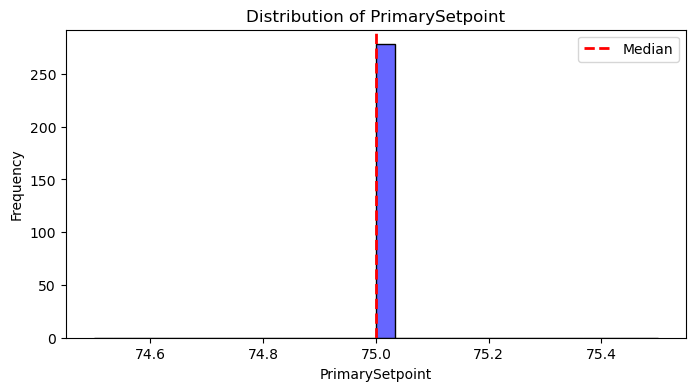

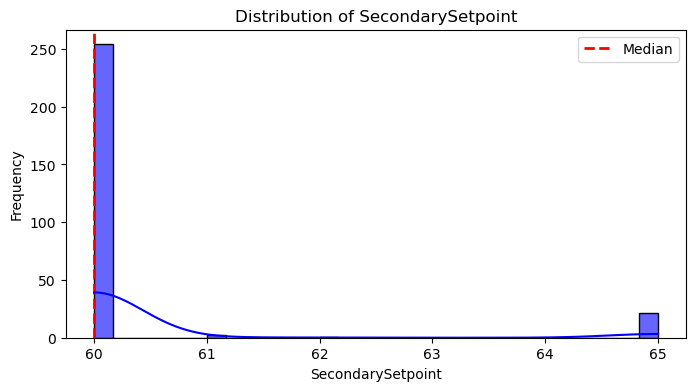

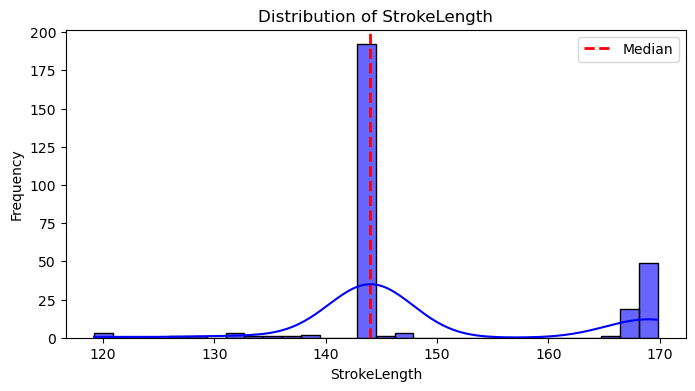

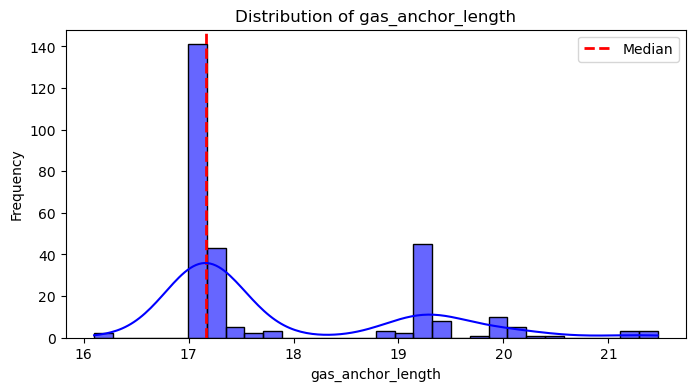

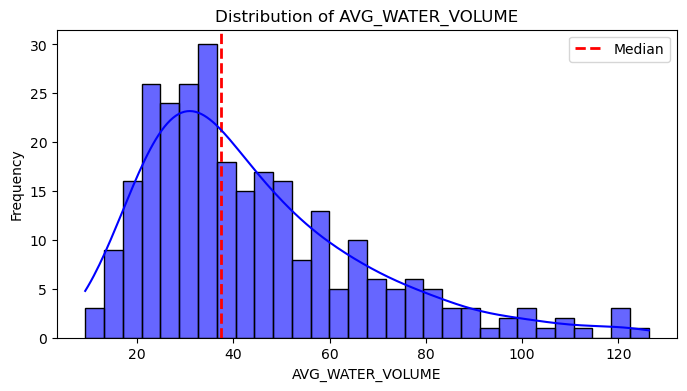

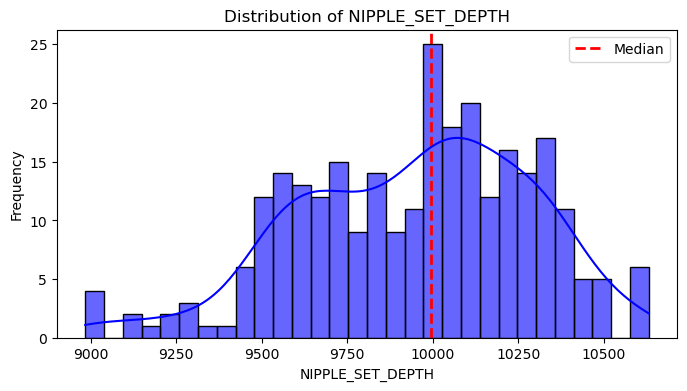

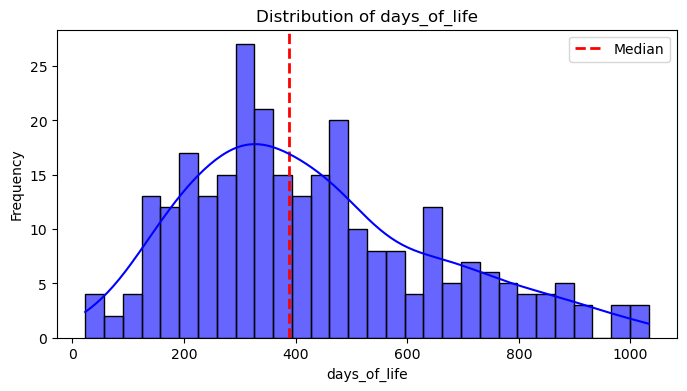

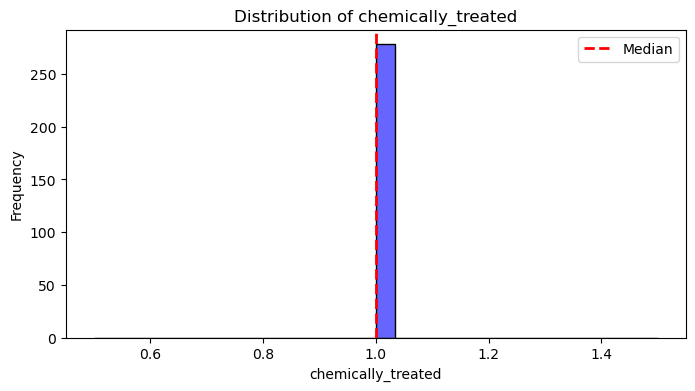

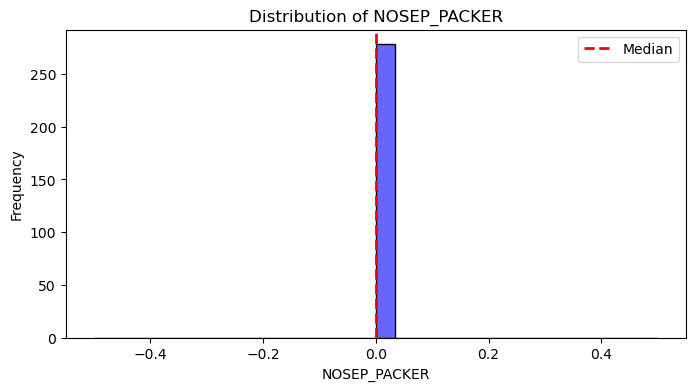

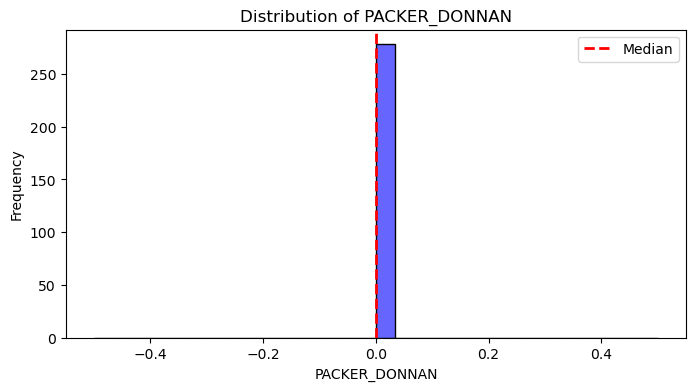

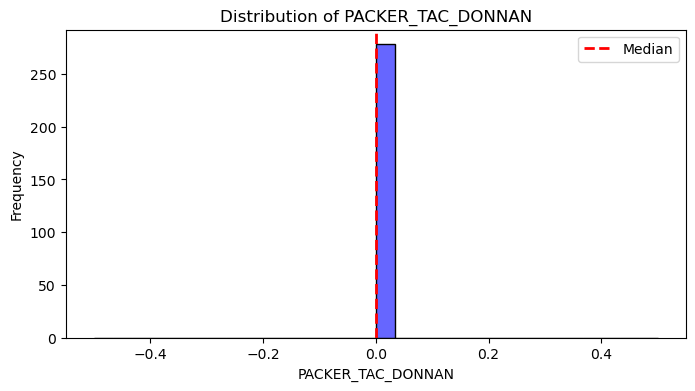

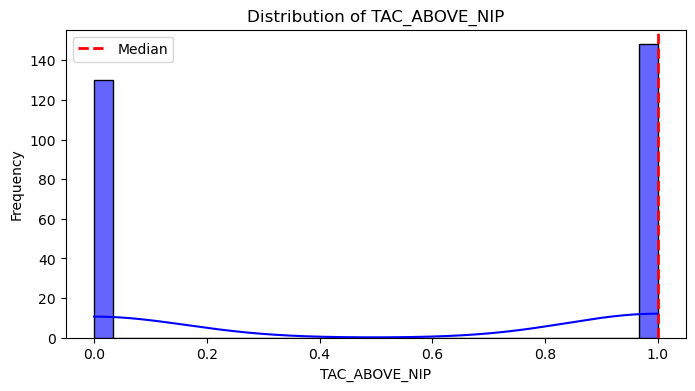

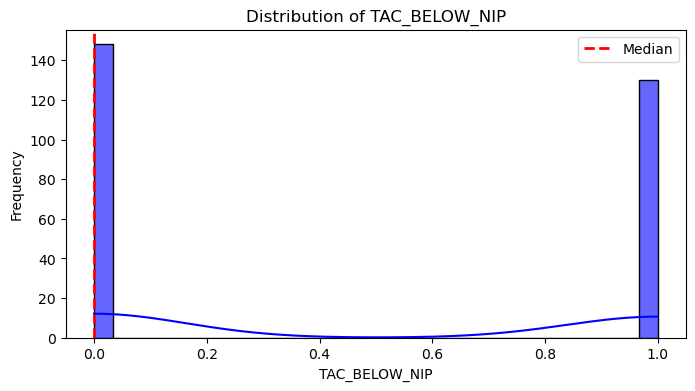

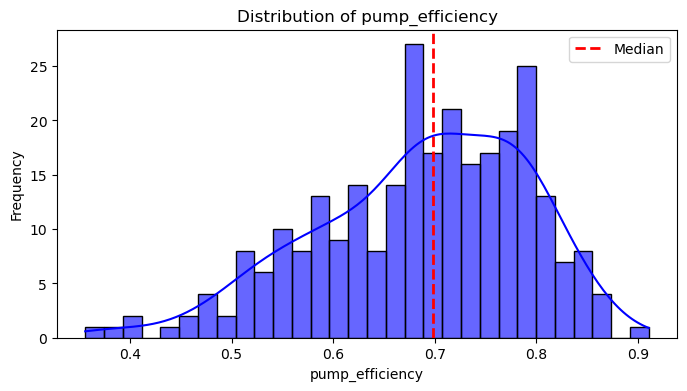

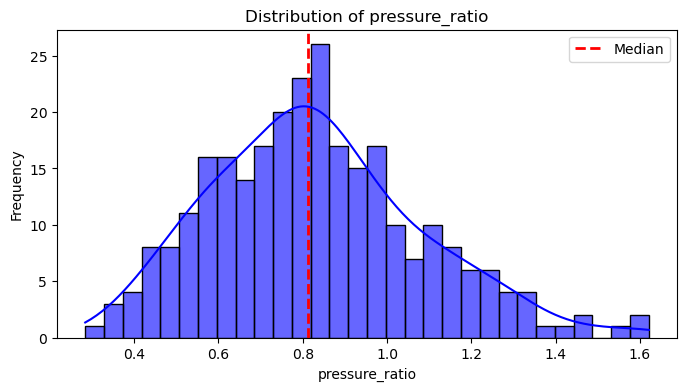

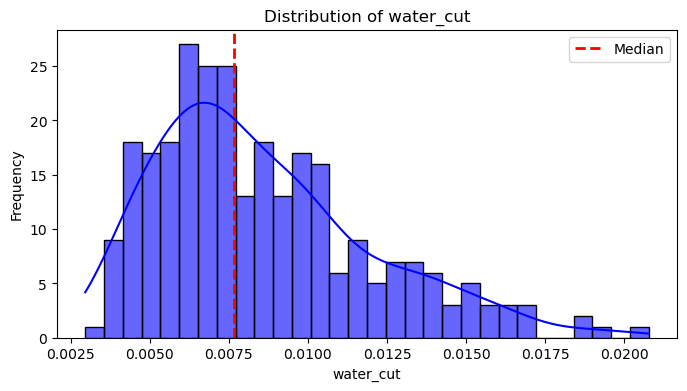

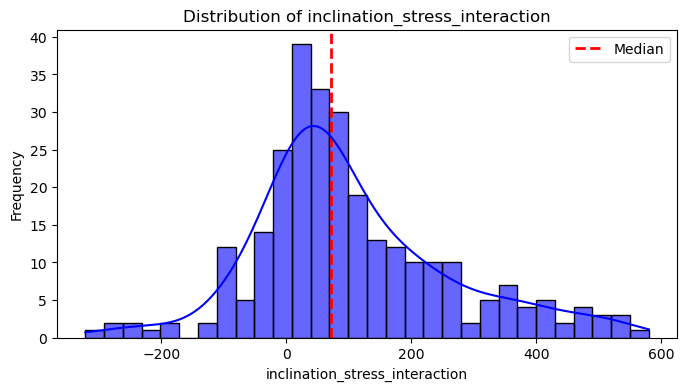

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset
file_path = "../cleanedData/IQROutliers.csv"
df = pd.read_csv(file_path)

# Select only numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns

# Plot bar charts with median line
import numpy as np

plt.figure(figsize=(15, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.figure(figsize=(8, 4))
    plt.axvline(df[col].median(), color='r', linestyle='dashed', linewidth=2, label='Median')
    sns.histplot(df[col], bins=30, kde=True, color="blue", alpha=0.6)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.legend(["Median"])
    plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.84      0.78        37
           1       0.83      0.92      0.88        38
           2       0.79      0.61      0.69        38

    accuracy                           0.79       113
   macro avg       0.79      0.79      0.78       113
weighted avg       0.79      0.79      0.78       113



<Figure size 1500x800 with 0 Axes>

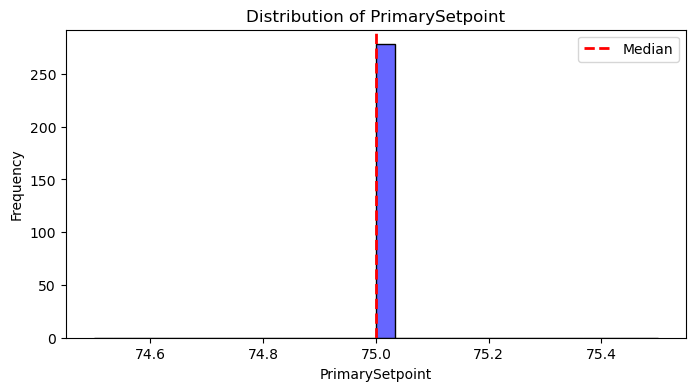

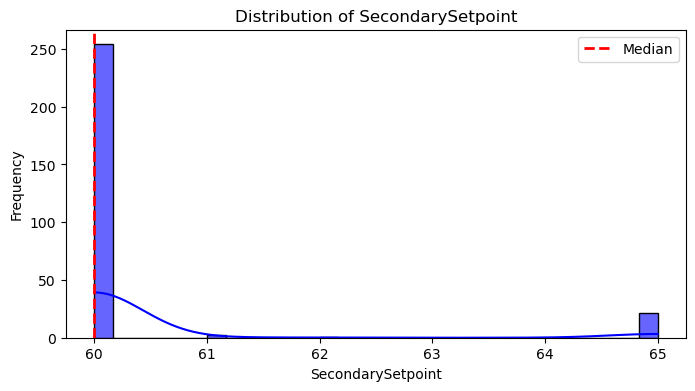

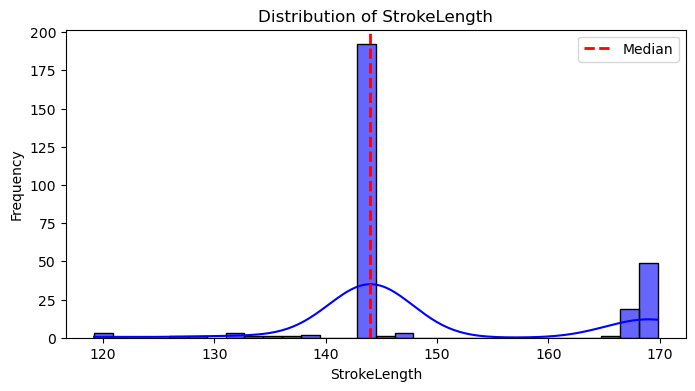

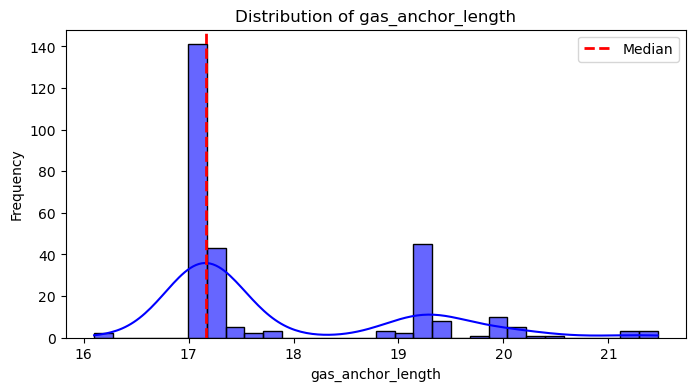

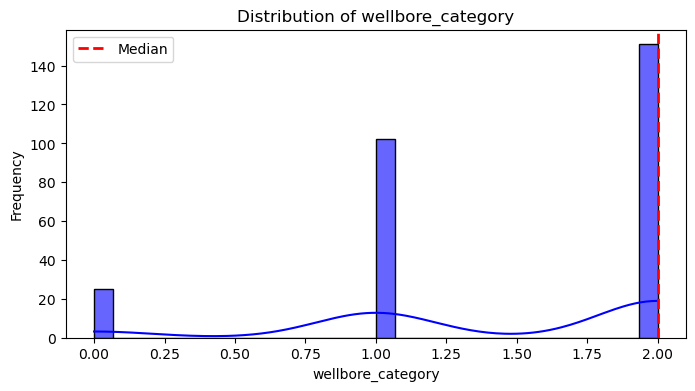

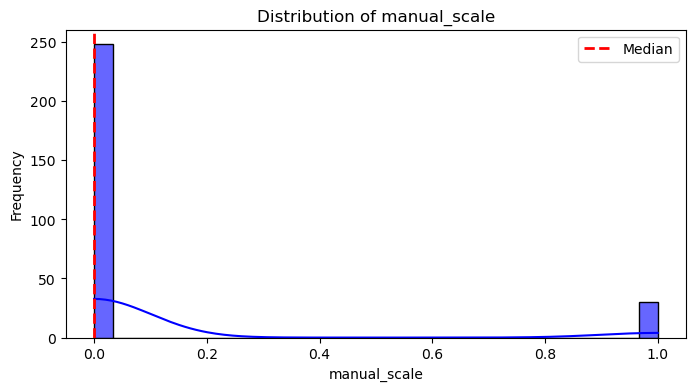

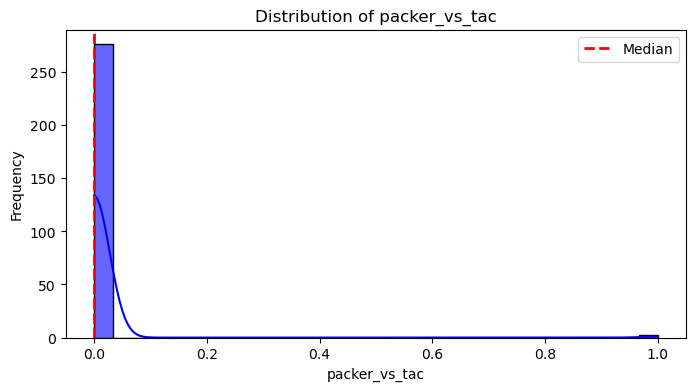

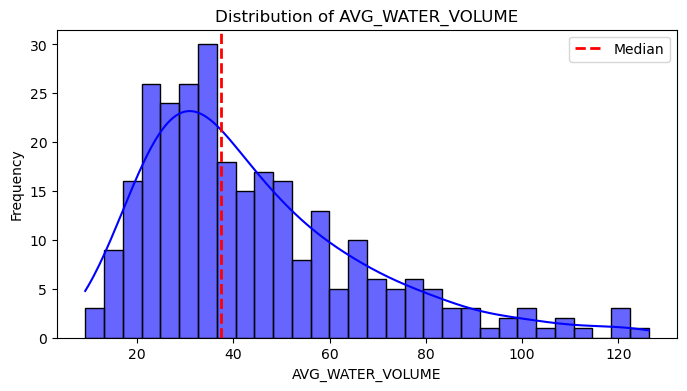

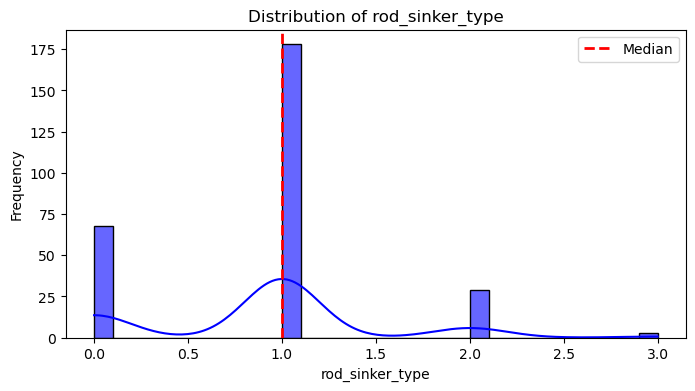

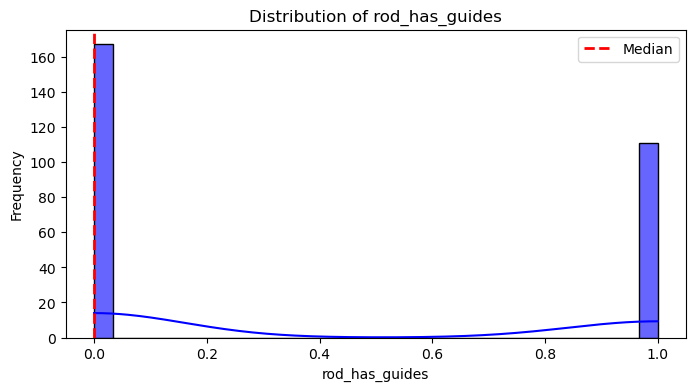

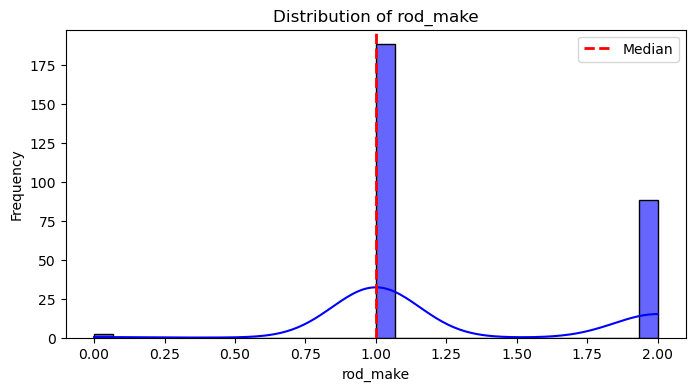

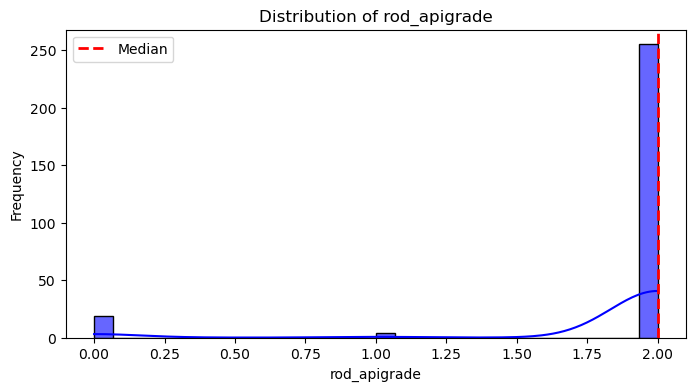

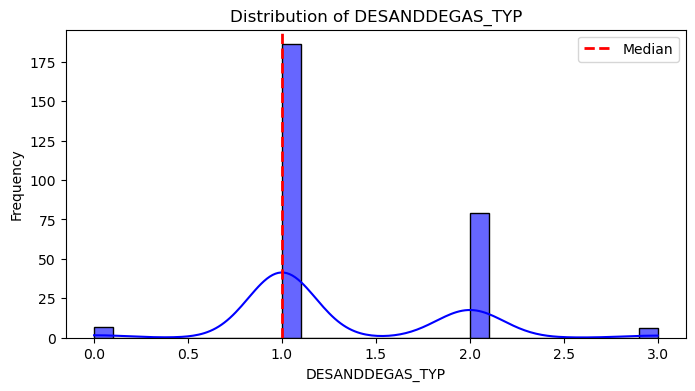

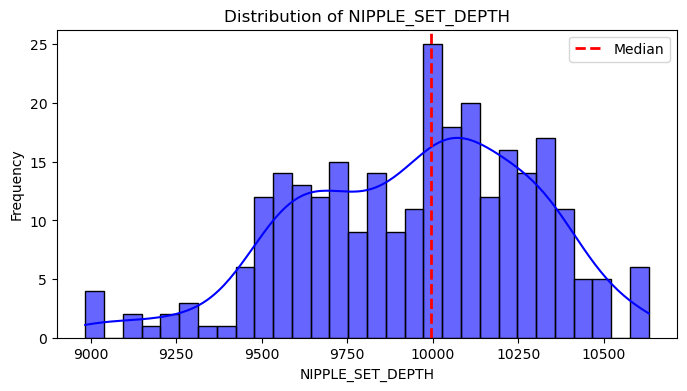

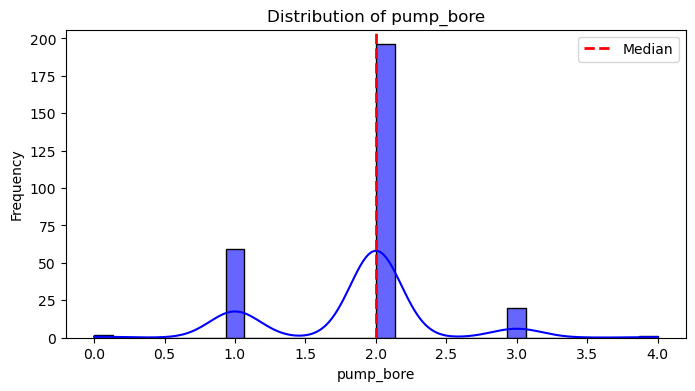

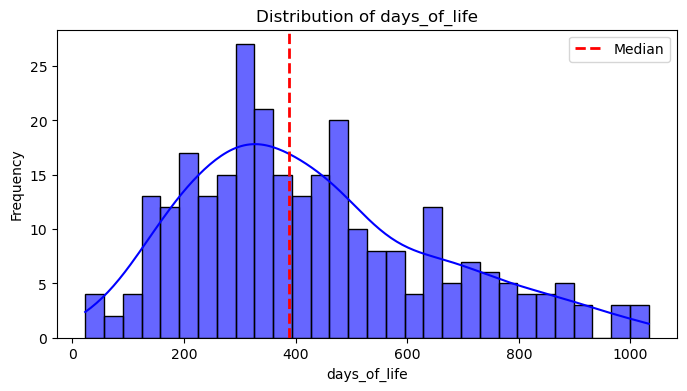

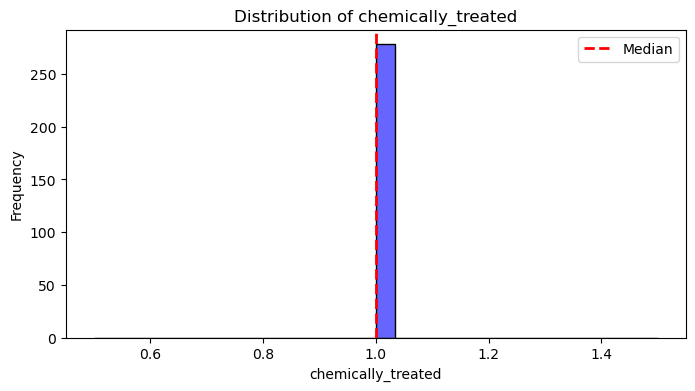

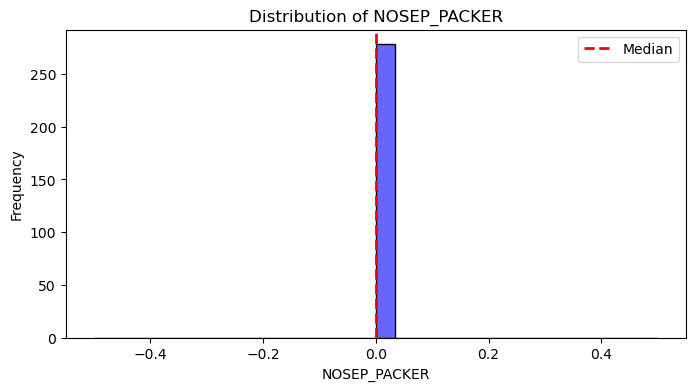

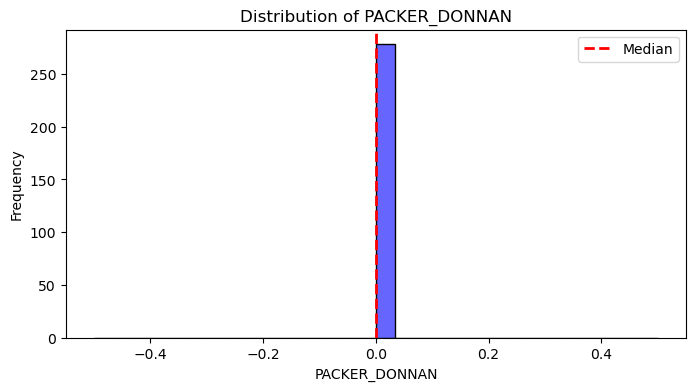

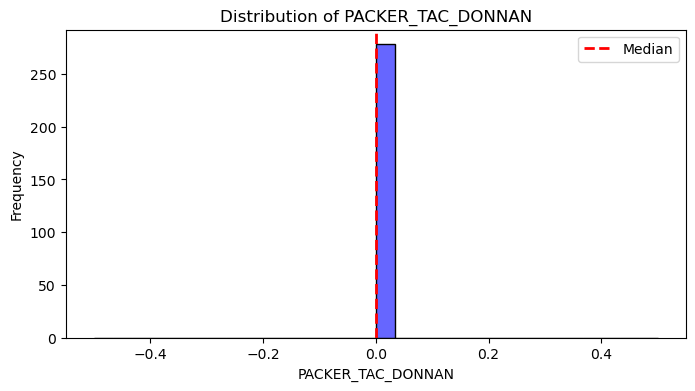

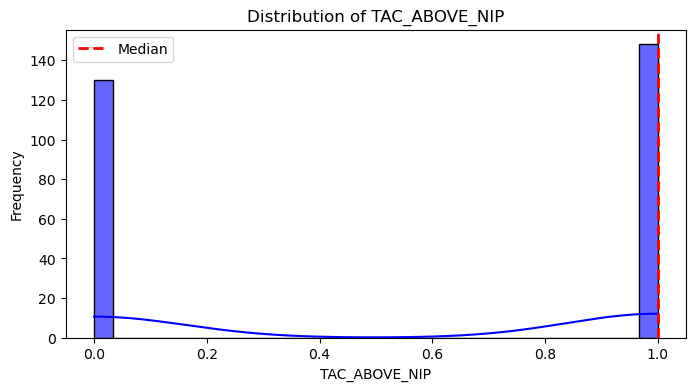

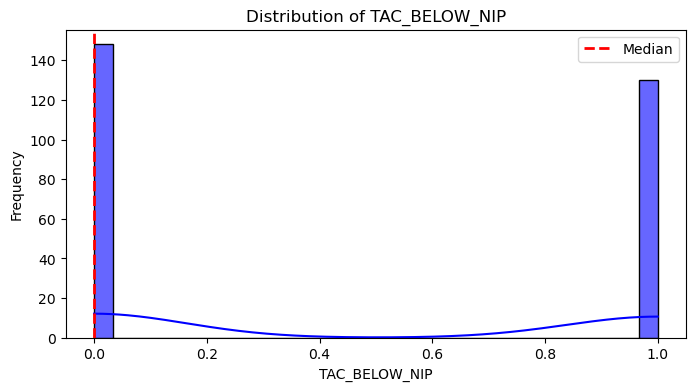

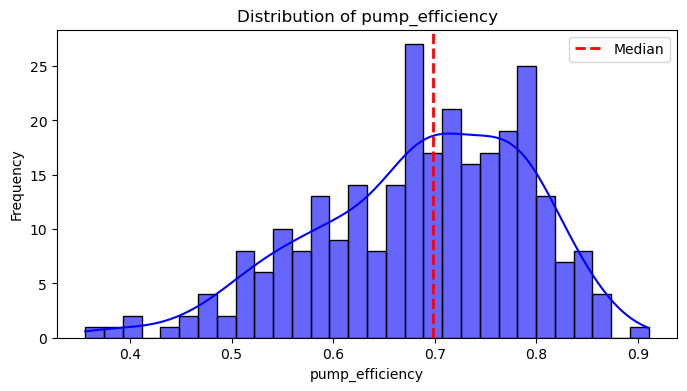

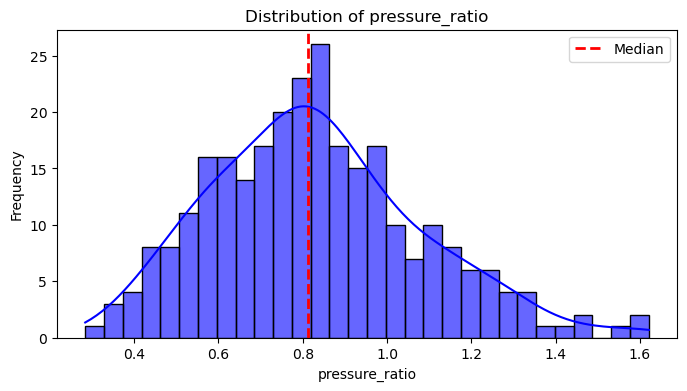

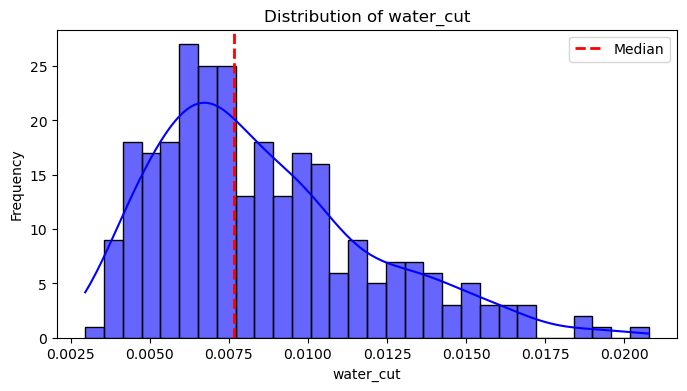

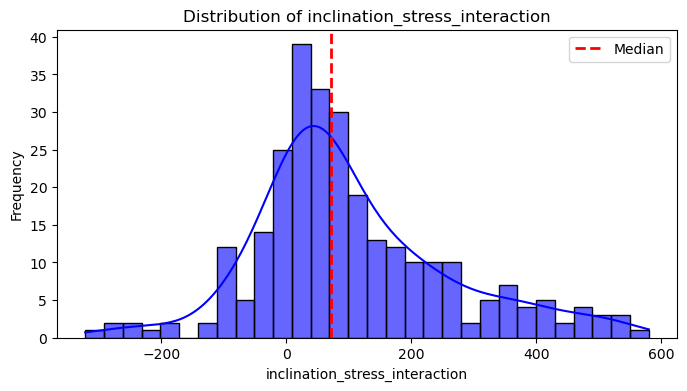

In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Load data
file_path = "../cleanedData/IQROutliers.csv"
df = pd.read_csv(file_path)

# Handle categorical columns by encoding them (if any)
# Example: You can use LabelEncoder or One-Hot Encoding for categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])

# Define features and target
X = df.drop(columns=['FAILURETYPE'])
y = df['FAILURETYPE']

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Define XGBoost classifier
xgb_model = XGBClassifier(objective='multi:softmax', num_class=len(y_train.unique()), eval_metric='mlogloss')

# Fit the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the feature distributions with median lines
plt.figure(figsize=(15, 8))
numeric_cols = X.columns
for i, col in enumerate(numeric_cols, 1):
    plt.figure(figsize=(8, 4))
    sns.histplot(X[col], bins=30, kde=True, color="blue", alpha=0.6)
    plt.axvline(X[col].median(), color='red', linestyle='dashed', linewidth=2, label='Median')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Load data
file_path = "../cleanedData/IQROutliers.csv"
df = pd.read_csv(file_path)

# Drop 'PrimarySetpoint' and 'SecondarySetpoint' columns
df = df.drop(columns=['PrimarySetpoint', 'SecondarySetpoint'])

# Save the cleaned data as 'DroppedPrimary'
df.to_csv("../cleanedData/DroppedPrimary.csv", index=False)



In [ ]:
import pandas as pd

# Load the cleaned dataset
file_path = "../cleanedData/DroppedPrimary.csv"
df = pd.read_csv(file_path)

# Group by 'wellbore_category' and 'failure_type' to see their relationship
failure_by_wellbore = df.groupby(['wellbore_category', 'FAILURETYPE']).size().reset_index(name='Count')

# Display the result
print(failure_by_wellbore)


  wellbore_category      FAILURETYPE  Count
0       HighTangent             Rods     10
1       HighTangent  Sucker Rod Pump      1
2       HighTangent           Tubing     14
3        LowTangent             Rods     20
4        LowTangent  Sucker Rod Pump     16
5        LowTangent           Tubing     66
6          Vertical             Rods     19
7          Vertical  Sucker Rod Pump     25
8          Vertical           Tubing    107


In [ ]:
import pandas as pd

# Load the cleaned data
file_path = "../cleanedData/DroppedPrimary.csv"
df = pd.read_csv(file_path)

# Create binary columns for each wellbore_category
wellbore_dummies = pd.get_dummies(df['wellbore_category'], prefix='wellbore')

# Join these new columns to the original dataframe
df_with_wellbore = pd.concat([df, wellbore_dummies], axis=1)

# Save the new dataframe as 'wellBore.csv'
df_with_wellbore.to_csv("../cleanedData/wellBore.csv", index=False)

print("wellBore.csv file created successfully!")


wellBore.csv file created successfully!


Top 10 Most Important Features:
              Feature  Importance
3        manual_scale    0.124035
18      TAC_ABOVE_NIP    0.075925
22          water_cut    0.075503
9        rod_apigrade    0.072363
0        StrokeLength    0.071436
12          pump_bore    0.059352
1   gas_anchor_length    0.057316
13       days_of_life    0.050947
2   wellbore_category    0.049651
11   NIPPLE_SET_DEPTH    0.046410


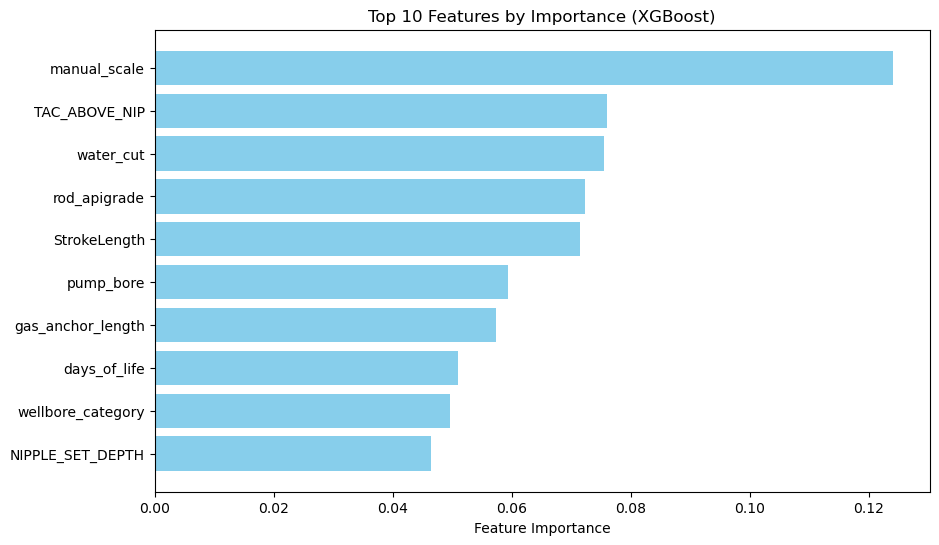

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Load the cleaned data
file_path = "../cleanedData/DroppedPrimary.csv"
df = pd.read_csv(file_path)

# Drop 'FAILURETYPE' for feature columns and separate target column
X = df.drop(columns=['FAILURETYPE'])
y = df['FAILURETYPE']

# Encode categorical features
categorical_cols = X.select_dtypes(include=['object']).columns
label_encoders = {}  # To store label encoders for each categorical feature

# Encode all categorical features
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])  # Encode the categorical feature
    label_encoders[col] = le  # Store the encoder for possible inverse transformation later

# Encode the target variable 'y' to numeric values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Define XGBoost classifier
xgb_model = XGBClassifier(objective='multi:softmax', num_class=len(label_encoder.classes_), eval_metric='mlogloss')

# Fit the model
xgb_model.fit(X, y_encoded)

# Get feature importances
feature_importance = xgb_model.feature_importances_

# Create a DataFrame to view feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 most important features
print("Top 10 Most Important Features:")
print(feature_importance_df.head(10))

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top 10 Features by Importance (XGBoost)')
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature on top
plt.show()


In [ ]:
import pandas as pd

# Load the new dataset (the one you want to enrich with H2S_CONCENTRATION)
new_file_path = '../cleanedData/DroppedPrimary.csv'
new_df = pd.read_csv(new_file_path)

# Load the old dataset (which contains AVG_WATER_VOLUME and H2S_CONCENTRATION)
old_file_path = '../data/rodpump_failure_final.csv'
old_df = pd.read_csv(old_file_path)

# Merge the datasets based on 'AVG_WATER_VOLUME'
# We want to add H2S_CONCENTRATION from the old dataset to the new dataset
enriched_df = pd.merge(new_df, old_df[['AVG_WATER_VOLUME', 'H2S_CONCENTRATION']], 
                       on='AVG_WATER_VOLUME', how='left')

# Save the final enriched dataset as 'CLEANEDFINAL.csv'
final_file_path = '../cleanedData/MEOW.csv'
enriched_df.to_csv(final_file_path, index=False)

print("Enrichment complete! The final dataset is saved as CLEANEDFINAL.csv.")


Enrichment complete! The final dataset is saved as CLEANEDFINAL.csv.


100%|██████████| 22/22 [00:05<00:00,  3.80it/s]



Cross-Validation Scores:  [0.77876106 0.80357143 0.78571429 0.73214286 0.875     ]
Mean Cross-Validation Accuracy:  0.7950379266750949
Standard Deviation of Cross-Validation Accuracy:  0.04642070702314476

Top Features Selected by mRMR and Their Importance:
                           Feature  Importance
7                        pump_bore    0.179225
11                    manual_scale    0.084139
6                     rod_apigrade    0.083174
1                wellbore_category    0.064892
0                        water_cut    0.060316
20                        rod_make    0.055041
2                 NIPPLE_SET_DEPTH    0.047164
21                 DESANDDEGAS_TYP    0.040513
19                   TAC_BELOW_NIP    0.038733
4          WaterCut_PumpEfficiency    0.037697
16                 rod_sinker_type    0.034142
17                    StrokeLength    0.032925
13                    days_of_life    0.032565
18                   TAC_ABOVE_NIP    0.031352
8   inclination_stress_interaction  

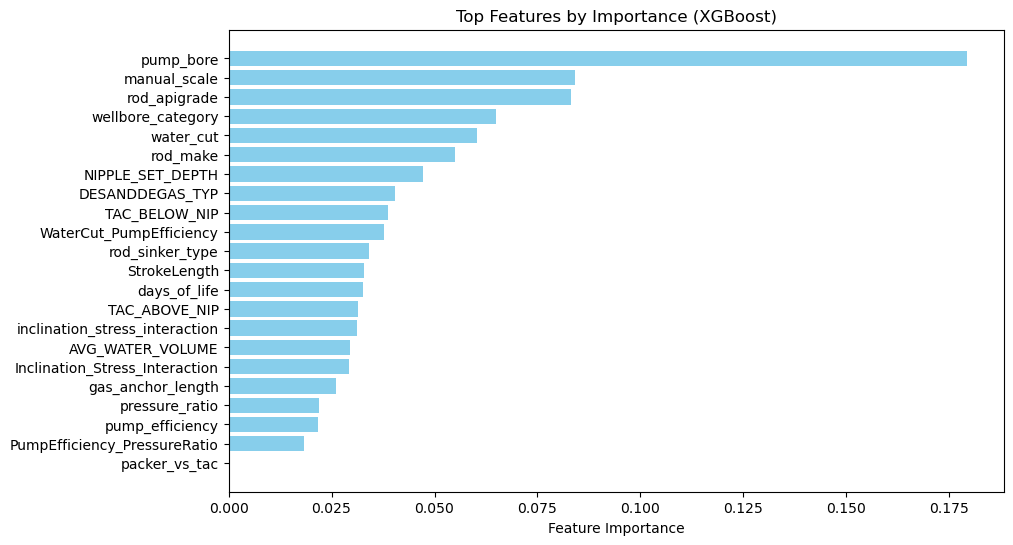

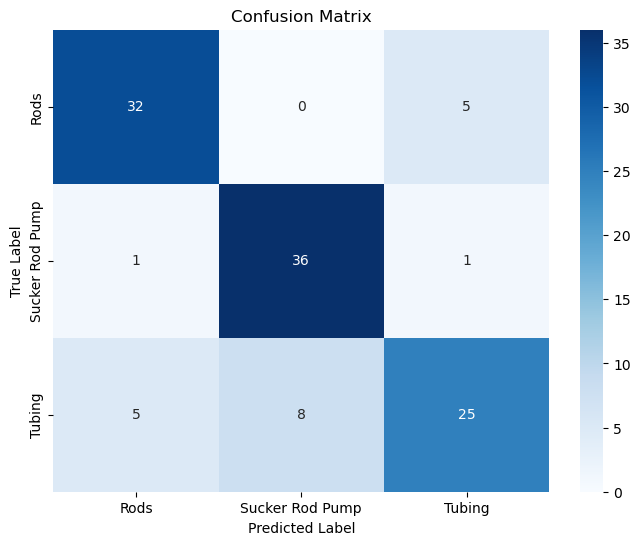


Mismatched Predictions:
             Actual        Predicted
3              Rods           Tubing
9            Tubing  Sucker Rod Pump
13           Tubing  Sucker Rod Pump
25  Sucker Rod Pump             Rods
29           Tubing             Rods
35           Tubing             Rods
38  Sucker Rod Pump           Tubing
41           Tubing  Sucker Rod Pump
47             Rods           Tubing
48             Rods           Tubing
60           Tubing  Sucker Rod Pump
63           Tubing  Sucker Rod Pump
74           Tubing             Rods
77           Tubing  Sucker Rod Pump
78             Rods           Tubing
87           Tubing             Rods
88           Tubing             Rods
92             Rods           Tubing
94           Tubing  Sucker Rod Pump
95           Tubing  Sucker Rod Pump

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85        37
           1       0.82      0.95      0.88        38
           

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, accuracy_score
from sklearn.preprocessing import LabelEncoder
from mrmr import mrmr_classif  # Install using: pip install mrmr-selection

# Load cleaned data
file_path = "../cleanedData/DroppedPrimary.csv"
df = pd.read_csv(file_path)

# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Encode categorical columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Feature engineering
df['PumpEfficiency_PressureRatio'] = df['pump_efficiency'] * df['pressure_ratio']
df['Inclination_Stress_Interaction'] = df['inclination_stress_interaction'] * df['pressure_ratio']
df['WaterCut_PumpEfficiency'] = df['water_cut'] * df['pump_efficiency']

# Define features and target
X = df.drop(columns=['FAILURETYPE'])
y = df['FAILURETYPE']

# Ensure X is numeric before applying mRMR
X = X.select_dtypes(include=[np.number])

# Apply mRMR feature selection
num_features = min(30, X.shape[1])  # Select top 30 features or all if fewer exist
selected_features = mrmr_classif(X=X, y=y, K=num_features)

# Reduce dataset to selected features
X_selected = X[selected_features]

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

# Initialize XGBoost model
xgb_model = XGBClassifier(objective='multi:softmax', num_class=len(y_resampled.unique()), eval_metric='mlogloss')

# Cross-validation setup (StratifiedKFold ensures balanced folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and capture the accuracy scores
cross_val_scores = cross_val_score(xgb_model, X_resampled, y_resampled, cv=cv, scoring='accuracy')

# Print cross-validation results
print("\nCross-Validation Scores: ", cross_val_scores)
print("Mean Cross-Validation Accuracy: ", cross_val_scores.mean())
print("Standard Deviation of Cross-Validation Accuracy: ", cross_val_scores.std())

# Optionally, train the model on the whole resampled data and evaluate results
xgb_model.fit(X_resampled, y_resampled)

# Feature importance
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display top features
print("\nTop Features Selected by mRMR and Their Importance:")
print(feature_importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top Features by Importance (XGBoost)')
plt.gca().invert_yaxis()
plt.show()

# Train-test split for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Train final XGBoost model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Convert failure type labels back to original class names
y_test_original = label_encoders["FAILURETYPE"].inverse_transform(y_test)
y_pred_original = label_encoders["FAILURETYPE"].inverse_transform(y_pred)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoders["FAILURETYPE"].classes_, yticklabels=label_encoders["FAILURETYPE"].classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print mismatched predictions
comparison_df = pd.DataFrame({'Actual': y_test_original, 'Predicted': y_pred_original})
print("\nMismatched Predictions:")
print(comparison_df[comparison_df['Actual'] != comparison_df['Predicted']])

# Model evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
